In [2]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../utils_mapping.R')    
})


# Reads

In [5]:
fastq_df <- fread('/data/srlab/ik936/Roche/data/eczema/SraRunTable.txt') %>% 
    janitor::clean_names() %>% 
    dplyr::select(run, geo_accession_exp)


# Load data

## library data

In [6]:
library(GEOquery)

In [7]:
x <- GEOquery::getGEO('GSE147424')$GSE147424_series_matrix.txt.gz


Found 1 file(s)

GSE147424_series_matrix.txt.gz

Parsed with column specification:
cols(
  ID_REF = col_character(),
  GSM4430459 = col_character(),
  GSM4430460 = col_character(),
  GSM4430461 = col_character(),
  GSM4430462 = col_character(),
  GSM4430463 = col_character(),
  GSM4430464 = col_character(),
  GSM4430465 = col_character(),
  GSM4430466 = col_character(),
  GSM4430467 = col_character(),
  GSM4430468 = col_character(),
  GSM4430469 = col_character(),
  GSM4430470 = col_character(),
  GSM4430471 = col_character(),
  GSM4430472 = col_character(),
  GSM4430473 = col_character(),
  GSM4430474 = col_character(),
  GSM4430475 = col_character()
)

File stored at: 

/tmp/RtmpGAwuf6/GPL16791.soft



In [8]:
library_df <- x@phenoData@data %>% 
    dplyr::select(title, geo_accession, matches(':ch1$')) %>% 
    janitor::clean_names() %>% 
    dplyr::mutate(LibraryID = gsub('(S\\d+)_.*', '\\1', title))

colnames(library_df) <- gsub('_ch1', '', colnames(library_df))


In [9]:
library_df

title  geo_accession disease           frozen_vs_fresh tissue_type 
1  S1_LS  GSM4430459    Atopic dermatitis Frozen          Lesional    
2  S2_LS  GSM4430460    Atopic dermatitis Frozen          Lesional    
3  S3_NL  GSM4430461    Atopic dermatitis Frozen          Non-lesional
4  S4_H   GSM4430462    Healthy           Frozen          Healthy     
5  S5_LS  GSM4430463    Atopic dermatitis Frozen          Lesional    
6  S6_H   GSM4430464    Healthy           Frozen          Healthy     
7  S7_LS  GSM4430465    Atopic dermatitis Frozen          Lesional    
8  S8_H   GSM4430466    Healthy           Fresh           Healthy     
9  S9_H   GSM4430467    Healthy           Frozen          Healthy     
10 S10_H  GSM4430468    Healthy           Frozen          Healthy     
11 S11_NL GSM4430469    Atopic dermatitis Frozen          Non-lesional
12 S12_H  GSM4430470    Healthy           Frozen          Healthy     
13 S13_H  GSM4430471    Healthy           Frozen          Healthy     
14 S14_NL GSM4430472    Atopic dermatitis Frozen          Non-lesional
15 S15_NL GSM4430473    Atopic dermatitis Frozen          Non-lesional
16 S16_NL GSM4430474    Atopic dermatitis Frozen          Non-lesional
17 S17_H  GSM4430475    Healthy           Frozen          Healthy     
   LibraryID
1  S1       
2  S2       
3  S3       
4  S4       
5  S5       
6  S6       
7  S7       
8  S8       
9  S9       
10 S10      
11 S11      
12 S12      
13 S13      
14 S14      
15 S15      
16 S16      
17 S17

## functions

In [13]:
sumOverRowNames <- function(X) {
    name_factors <- factor(row.names(X))
    res <- presto::sumGroups(X, name_factors)
    row.names(res) <- levels(name_factors)#[1:nrow(res)]
    colnames(res) <- colnames(X)
    return(res)
}


## Kallisto re-mapped

In [12]:
exprs_raw <- readRDS('/data/srlab/ik936/Roche/data/cache/exprs_raw_matrix_eczema.rds')

## meta data 

In [36]:
mito_genes <- grep("^MT-", rownames(exprs_raw), value = TRUE, ignore.case = TRUE)
meta_data <- tibble(
    CellID = colnames(exprs_raw),
    LibraryID = gsub("^(.*?)_(.*)", "\\2", CellID),
    nGene = Matrix::colSums(exprs_raw != 0), 
    nUMI = Matrix::colSums(exprs_raw), 
    percent_mito = Matrix::colSums(exprs_raw[mito_genes, ])/Matrix::colSums(exprs_raw)   
) %>% 
    ## SRR to GEO IDs
    left_join(fastq_df, by = c('LibraryID' = 'run')) %>% 
    ## sample level info 
    left_join(library_df %>% dplyr::select(-LibraryID), by = c('geo_accession_exp' = 'geo_accession'))

In [38]:
head(meta_data)

CellID                       LibraryID   nGene nUMI  percent_mito
1 AAACCTGAGAGCTATA_SRR11396159 SRR11396159 3467  23404 0.062382499 
2 AAACCTGCAACAACCT_SRR11396159 SRR11396159  810   1404 0.038461538 
3 AAACCTGGTAGAGTGC_SRR11396159 SRR11396159 1244   2650 0.064528302 
4 AAACCTGGTATCAGTC_SRR11396159 SRR11396159 2050   4839 0.008266171 
5 AAACCTGTCCTTTCGG_SRR11396159 SRR11396159  670   1156 0.102076125 
6 AAACCTGTCGGAAATA_SRR11396159 SRR11396159 1627   4193 0.057953732 
  geo_accession_exp title disease           frozen_vs_fresh tissue_type
1 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
2 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
3 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
4 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
5 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
6 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional

In [39]:
table(meta_data$tissue_type)
with(meta_data, table(LibraryID, frozen_vs_fresh))
table(meta_data$disease)



     Healthy     Lesional Non-lesional 
       22326         9917         5583 

             frozen_vs_fresh
LibraryID     Fresh Frozen
  SRR11396159     0   3973
  SRR11396160     0   2182
  SRR11396161     0   1908
  SRR11396162     0   6429
  SRR11396163     0   2288
  SRR11396164     0   2169
  SRR11396165     0   1474
  SRR11396166  4310      0
  SRR11396167     0   5524
  SRR11396168     0    780
  SRR11396169     0   2331
  SRR11396170     0   1977
  SRR11396171     0    204
  SRR11396172     0    916
  SRR11396173     0    330
  SRR11396174     0     98
  SRR11396175     0    933


Atopic dermatitis           Healthy 
            15500             22326 

## QC

Picking joint bandwidth of 0.0492



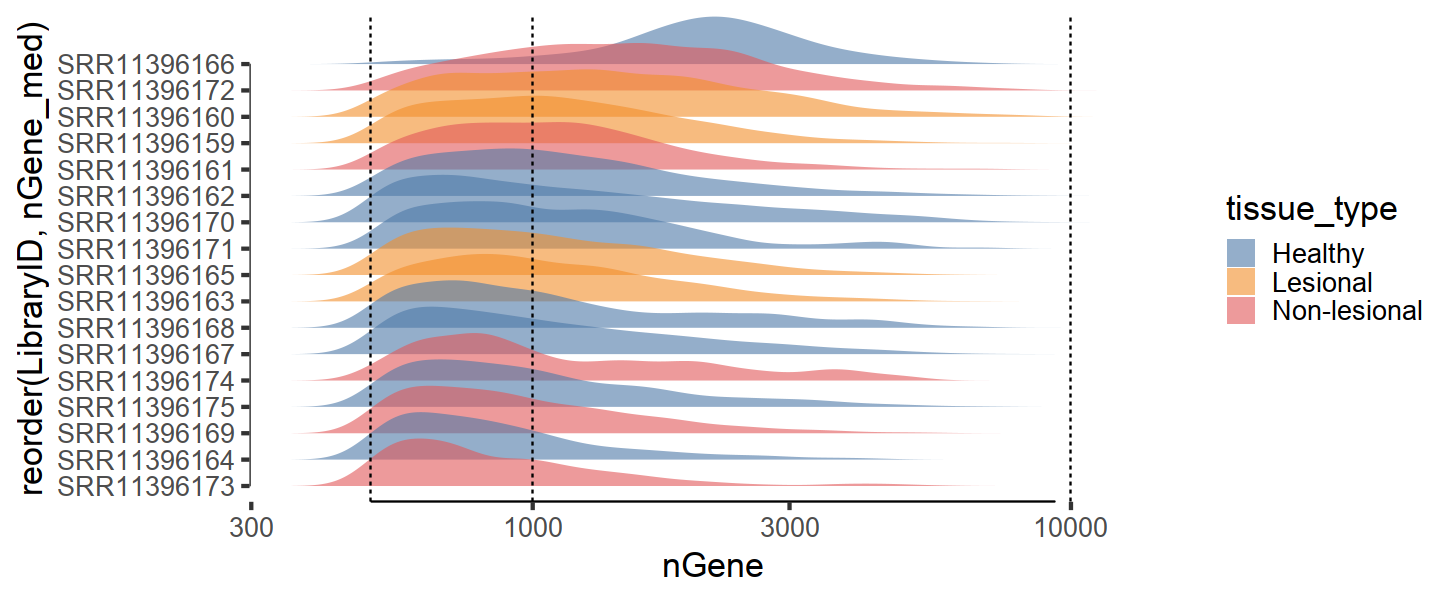

In [43]:
fig.size(5, 12)
data.table(meta_data)[
    , nGene_med := median(as.numeric(nGene)), by = LibraryID
][] %>% 
    ggplot(aes(nGene, reorder(LibraryID, nGene_med), fill = tissue_type)) + 
        geom_density_ridges2(aes(height = ..ndensity..), alpha = .6, color = NA) + 
        theme_tufte(base_size = 20) + geom_rangeframe(color = 'black') + 
        scale_x_continuous(trans = 'log10') + 
        geom_vline(xintercept = c(500, 1e3, 1e4), linetype = 2) + 
        scale_fill_tableau() + 
#         facet_wrap(~cell_subtype_ch1, ncol = 2) + 
        NULL


Remove one outlier sample

In [45]:
meta_data <- meta_data %>% 
#     subset(!LibraryID %in% c('S15')) %>% ## lowest library complexity 
    subset(!LibraryID %in% c('SRR11396166')) ## only fresh sample


In [46]:
exprs_raw <- exprs_raw[, meta_data$CellID]

In [47]:
exprs_raw <- exprs_raw %>% as('matrix') %>% as('dgCMatrix')

In [48]:
dim(exprs_raw)

[1] 19952 33516

## Doublets

In [150]:
library(scDblFinder)
library(scater)
library(singlecellmethods)


scDblFinder_par <- function(counts, library_ids, logcounts=NULL, ncore=1) {
    if (is.null(logcounts)) {
        logcounts <- singlecellmethods::normalizeData(counts, 1e4, 'log')
    }
    logcounts_list <- split(seq_len(ncol(counts)), library_ids) %>% 
        map(function(idx) {
            logcounts[, idx]
        })

    counts_list <- split(seq_len(ncol(counts)), library_ids) %>% 
        map(function(idx) {
            counts[, idx]
        })

    if (ncore == 1) {
        future::plan(sequential)
    } else if (ncore %in% c(0, Inf)) {
        ncore <- availableCores()
        future::plan(multiprocess)
    } else {
        ## TODO: remove this assignment that pollutes the global environment 
        .ncore <<- ncore
        future::plan(future::multiprocess(workers = .ncore))
    }
    future_map2(logcounts_list, counts_list, function(.logcounts, .counts) {
            sce <- SingleCellExperiment(list(counts = .counts,logcounts = .logcounts))
            sce <- scDblFinder(sce, verbose=FALSE)
            as.data.frame(sce@colData) %>% 
                tibble::rownames_to_column('CellID')
        }) %>% 
        bind_rows(.id = 'LibraryID')
}


In [149]:
res <- scDblFinder_par(
    counts = exprs_raw,
    library_ids = meta_data$LibraryID,
    ncore = 16
)


Warning message in scDblFinder(sce, verbose = FALSE):
“scDblFinder might not work well with very low 
numbers of cells.”


In [152]:
table(meta_data$LibraryID)


SRR11396159 SRR11396160 SRR11396161 SRR11396162 SRR11396163 SRR11396164 
       3973        2182        1908        6429        2288        2169 
SRR11396165 SRR11396167 SRR11396168 SRR11396169 SRR11396170 SRR11396171 
       1474        5524         780        2331        1977         204 
SRR11396172 SRR11396173 SRR11396174 SRR11396175 
        916         330          98         933 

In [153]:
with(res, table(LibraryID, scDblFinder.class))

             scDblFinder.class
LibraryID     doublet singlet
  SRR11396159     144    3829
  SRR11396160      44    2138
  SRR11396161      36    1872
  SRR11396162     433    5996
  SRR11396163      50    2238
  SRR11396164      47    2122
  SRR11396165      22    1452
  SRR11396167     278    5246
  SRR11396168       7     773
  SRR11396169      49    2282
  SRR11396170      39    1938
  SRR11396171       3     201
  SRR11396172       8     908
  SRR11396173       4     326
  SRR11396174       1      97
  SRR11396175      10     923

In [156]:
meta_data <- meta_data %>% 
    left_join(res) %>% 
    subset(!LibraryID %in% c('SRR11396174', 'SRR11396171', 'SRR11396173')) %>% 
    subset(scDblFinder.class == 'singlet')


Joining, by = c("CellID", "LibraryID")



In [157]:
exprs_raw <- exprs_raw[, meta_data$CellID]

## Cache

In [158]:
saveRDS(meta_data, '/data/srlab/ik936/Roche/data/eczema/cache_meta_data.rds')
saveRDS(exprs_raw, '/data/srlab/ik936/Roche/data/eczema/cache_exprs_raw.rds')


# All cells

In [80]:
meta_data <- readRDS('/data/srlab/ik936/Roche/data/eczema/cache_meta_data.rds')
exprs_raw <- readRDS('/data/srlab/ik936/Roche/data/eczema/cache_exprs_raw.rds')


## Create object

Because the data is already normalized, modify fxn to not take in raw counts. 

In [126]:
# create_object <- function (exprs_norm, meta_data, npcs = 30, var_genes = NULL, 
#     split_vargenes_by = NULL, nvargenes = 2000, verbose = FALSE, 
#     max_mt = Inf, min_ngene = 0, max_numi = Inf, gene_exclude_pattern = "^MT-|^RPS|^RPL") 
# {
#     obj <- list()
#     message("start filter")
#     meta_data <- meta_data %>% dplyr::filter(percent_mito < max_mt & 
#         nGene >= min_ngene & nUMI < max_numi)
#     exprs_norm <- exprs_norm[, meta_data$CellID]
#     if (!"weight" %in% colnames(meta_data)) {
#         warning("weights not initialized in metadata. Setting all to 1.")
#         meta_data$weight <- rep(1, nrow(meta_data))
#     }
#     obj$meta_data <- meta_data
#     obj$exprs_norm <- exprs_norm
#     if (verbose) {
#         print(t)
#         message("Finished normalization")
#     }
#     if (is.null(var_genes)) {
#         message("start vargenes")
#         t <- system.time({
#             if (missing(split_vargenes_by)) {
#                 var_genes <- singlecellmethods::vargenes_vst(exprs_norm, 
#                   topn = nvargenes)
#             }
#             else {
#                 var_genes <- singlecellmethods::vargenes_vst(exprs_norm, 
#                   meta_data[[split_vargenes_by]], topn = nvargenes)
#             }
#         })
#         if (verbose) {
#             print(t)
#             message("Finished vargenes")
#         }
#     }
#     else {
#         var_genes <- intersect(var_genes, rownames(obj$exprs_norm))
#     }
#     obj$var_genes <- var_genes
#     message("start pca")
#     t <- system.time({
#         pca_res <- weighted_pca(exprs_norm[obj$var_genes, ], 
#             meta_data[["weight"]], npc = npcs)
#     })
#     if (verbose) {
#         print(t)
#         message("Finished PCA")
#     }
#     obj$V <- pca_res$embeddings
#     obj$loadings <- pca_res$loadings
#     obj$vargenes_means_sds <- pca_res$vargenes
#     return(obj)
# }

In [81]:
obj <- create_object(
    exprs_raw, 
    meta_data, 
    min_ngene=500, 
    max_mt=0.2
)


start filter

Warning message in create_object(exprs_raw, meta_data, min_ngene = 500, max_mt = 0.2):
“weights not initialized in metadata. Setting all to 1.”
start normalization

start vargenes

start pca



In [74]:
# obj$exprs_raw <- exprs_raw[, obj$meta_data$CellID]

## UMAP

In [82]:
umap_after_fname <- tempfile(tmpdir = '/data/srlab/ik936/Roche/data/cache', pattern = 'umap_')
umap_res <- do_umap(obj$V, umap_after_fname)


Warning message:
“invalid uid value replaced by that for user 'nobody'”


In [83]:
obj$umap_after_fname = umap_after_fname
obj$umap_after = umap_res$embedding
obj$adj_after = umap_res$adj
obj$knn_after = umap_res$knn


In [84]:
head(obj$meta_data)

CellID                       LibraryID   nGene nUMI percent_mito
1 AAACCTGCAACAACCT_SRR11396159 SRR11396159  810  1404 0.03846154  
2 AAACCTGGTAGAGTGC_SRR11396159 SRR11396159 1244  2650 0.06452830  
3 AAACCTGTCCTTTCGG_SRR11396159 SRR11396159  670  1156 0.10207612  
4 AAACCTGTCGGAAATA_SRR11396159 SRR11396159 1627  4193 0.05795373  
5 AAACGGGAGTTTCCTT_SRR11396159 SRR11396159  954  1709 0.02867174  
6 AAACGGGCAAGGTGTG_SRR11396159 SRR11396159  675  1672 0.13696172  
  geo_accession_exp title disease           frozen_vs_fresh tissue_type
1 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
2 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
3 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
4 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
5 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
6 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
  scDblFinder.weighted scDblFinder.ratio scDblFinder.score scDblFinder.class
1 0.04719531           0.05              0.04719531        singlet          
2 0.26460159           0.25              0.26460159        singlet          
3 0.00000000           0.00              0.00000000        singlet          
4 0.15361019           0.15              0.15361019        singlet          
5 0.00000000           0.00              0.00000000        singlet          
6 0.04753962           0.05              0.04753962        singlet          
  weight
1 1     
2 1     
3 1     
4 1     
5 1     
6 1

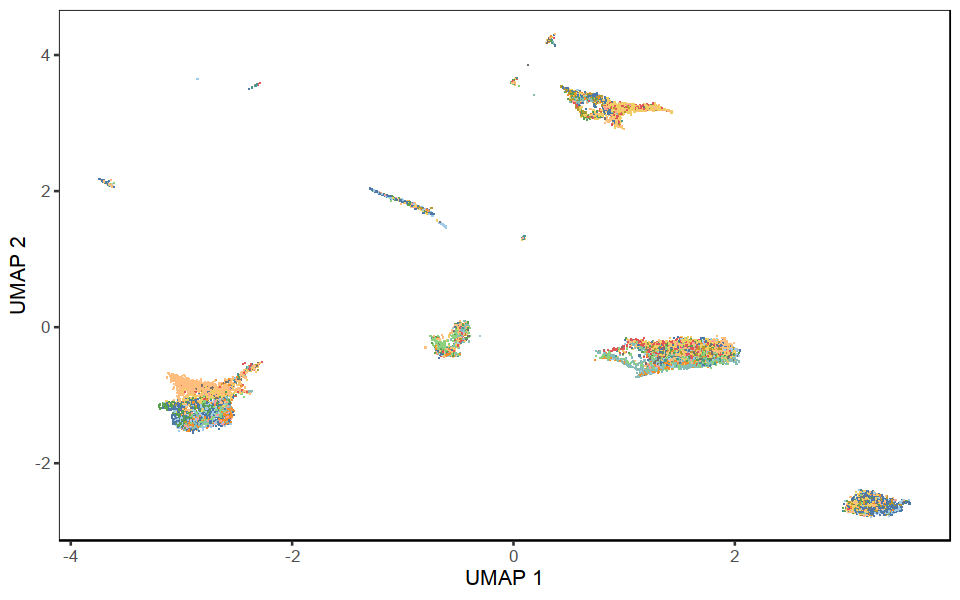

In [85]:
fig.size(5, 8)
do_scatter(obj$umap_after, obj$meta_data, 'LibraryID', do_labels = FALSE)


## Markers

In [99]:
lineage_markers <- list(
    epithelial = c('KRT15', 'MLANA', 'IL1R2'),
#     sweat_glands = c('GLS', 'TMEM87A', 'IGFBP7'), 
#     MEL_NC_SC = c('DCT', 'MLANA', 'TYRP1'), 
    endothelial = c('VWF', 'NOTCH4', 'PODXL', 'LYVE1'),
    mural = c('NOTCH3'),
#     plasma = c('JCHAIN', 'MZB1'),
    fibroblast = c('PDPN', 'ABCA8'),
    haematopoietic = c('PTPRC', 'CD3E', 'CD14', 'MS4A1')
#     roche = c('CCL19', 'COL3A1', 'SPARC', 'POSTN', 'MAFF')
#     glial = c('CRYAB', 'S100B')
)


setdiff(unique(unlist(lineage_markers)), rownames(obj$exprs_norm))

character(0)

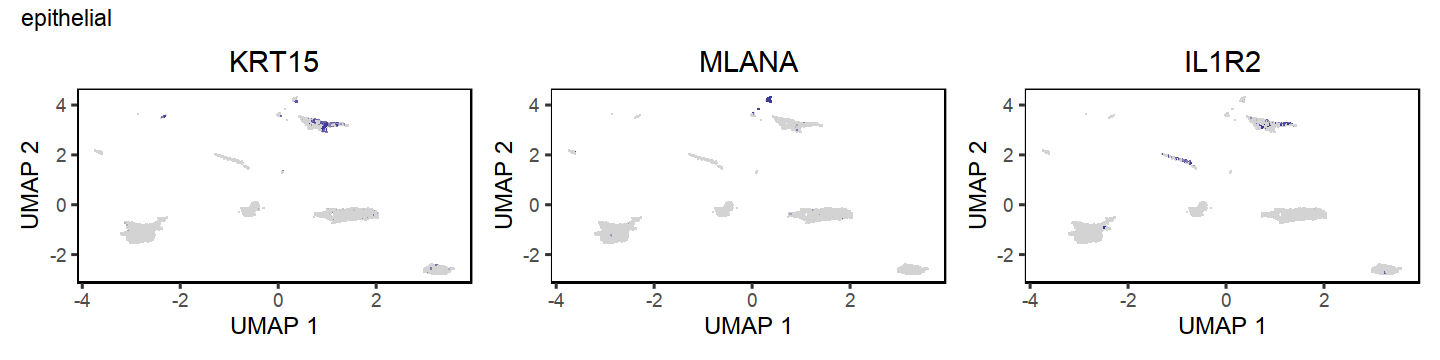

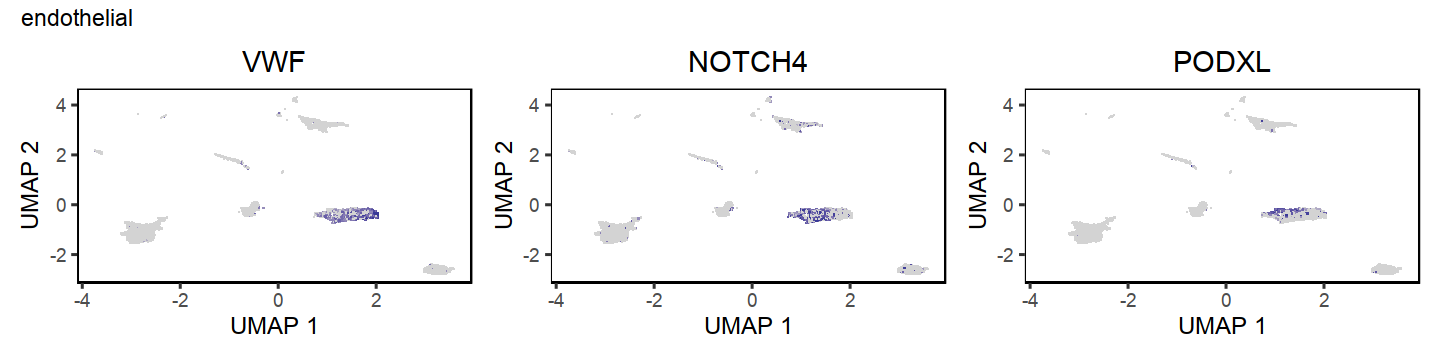

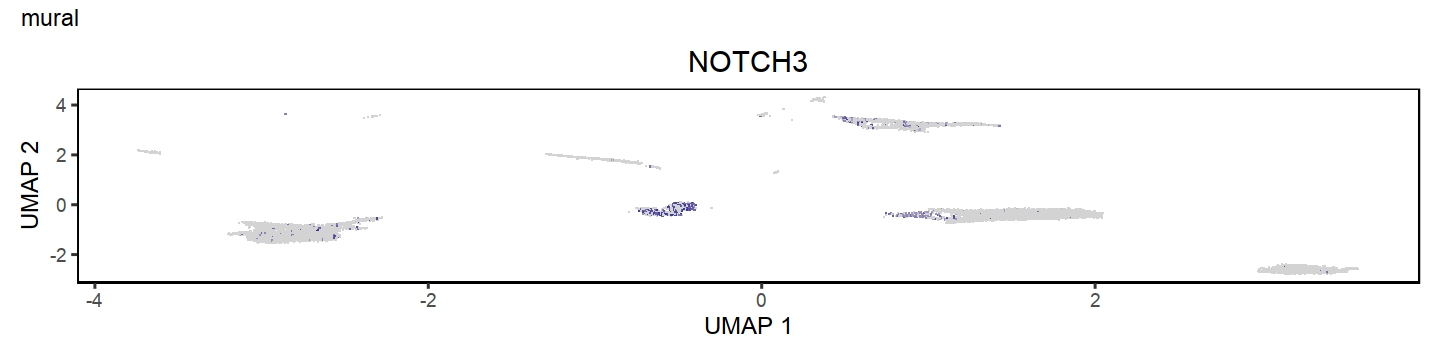

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]


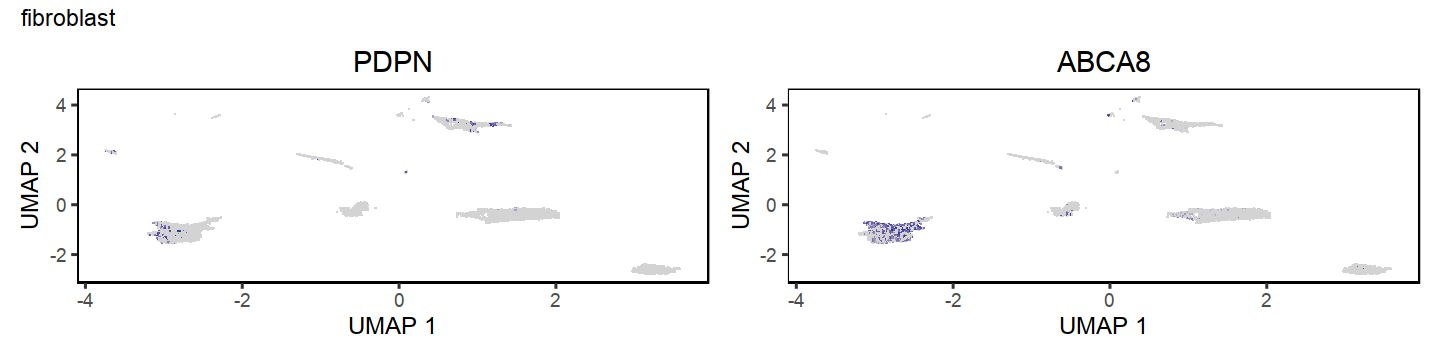

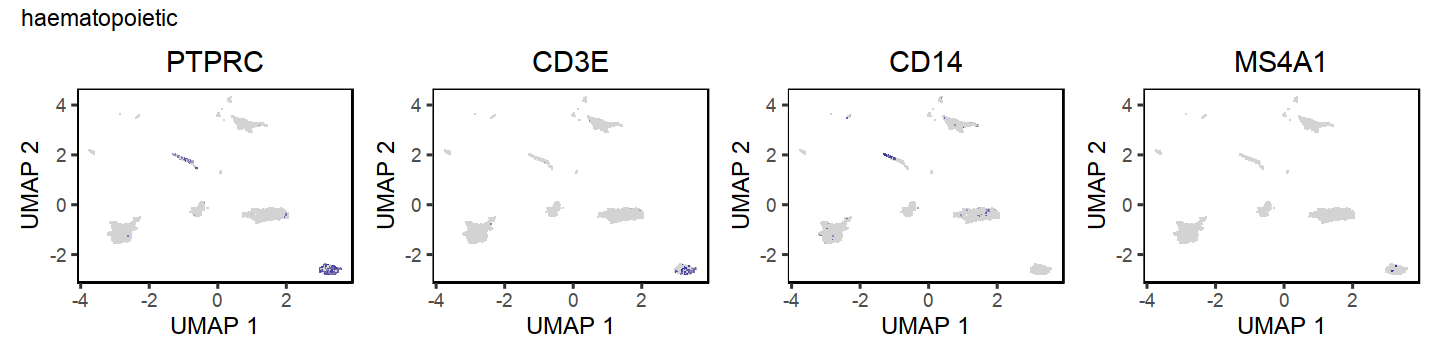

In [98]:
fig.size(3, 12)
with(obj, {
    lapply(names(lineage_markers), function(group) {
        plotFeatures(exprs_norm, umap_after,
                     intersect(lineage_markers[[group]], row.names(exprs_norm)), 
                     qhi = .99, no_guide = TRUE) + 
            plot_annotation(title = group)
    })    
})


## Louvain


In [90]:
set.seed(3)
future::plan(multiprocess)
t_cluster <- system.time({
    obj <- do_cluster(
        obj, 'adj_after', c(.1, .3, .5),
        append_cols = FALSE, 
        force_snn = TRUE,
        slot_name = 'clusters_df', 
        do_weights = FALSE
        
    )
})


Registered S3 method overwritten by 'pryr':
  method      from
  print.bytes Rcpp

0.1

0.3

0.5

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3

finished Louvain



Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


[[1]]


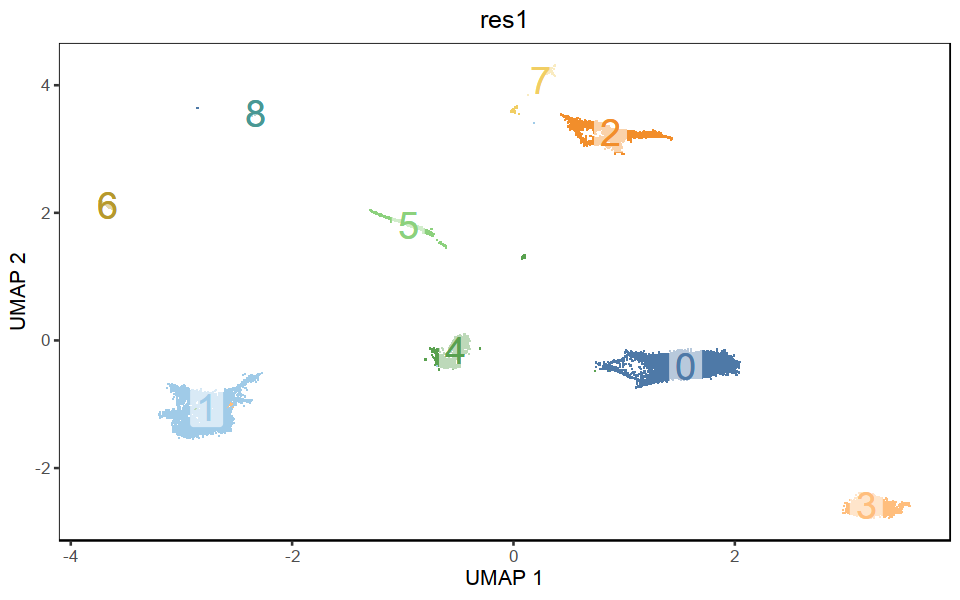

In [91]:
fig.size(5, 8)
plot_clusters(obj, 'umap_after', 'res1')


In [100]:
obj$meta_data$lineage <- case_when(
    obj$clusters_df$res1 %in% c('0') ~ 'vascular_EC',
    obj$clusters_df$res1 %in% c('1') ~ 'fibroblast',
    obj$clusters_df$res1 %in% c('3') ~ 'tcell', 
    obj$clusters_df$res1 %in% c('5') ~ 'mono', 
    obj$clusters_df$res1 %in% c('2', '8') ~ 'epithelial', 
    obj$clusters_df$res1 %in% c('4') ~ 'mural', 
    obj$clusters_df$res1 %in% c('7') ~ 'melanocyte',
    obj$clusters_df$res1 %in% c('6') ~ 'lymphatic_EC'
#     TRUE ~ 'UNKNOWN'
)


In [101]:
# mres <- wilcoxauc(obj$exprs_norm, obj$clusters_df$res1)

# mres %>% 
#     subset(auc > 0.5) %>% 
#     subset(group == '7') %>% 
#     arrange(-auc) %>% 
#     head(20)


Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


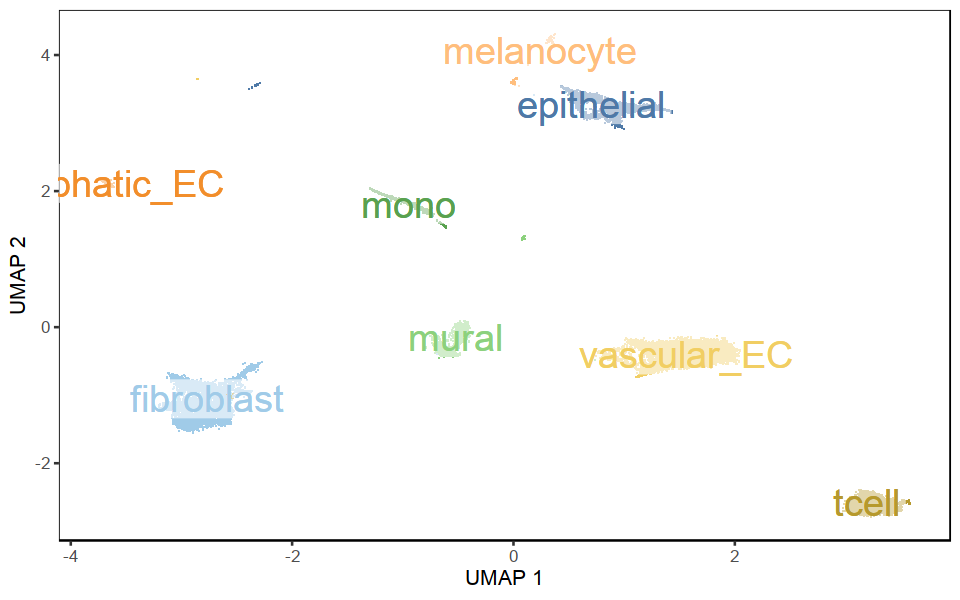

In [102]:
fig.size(5, 8)
do_scatter(obj$umap_after, obj$meta_data, 'lineage', pt_size = 8)


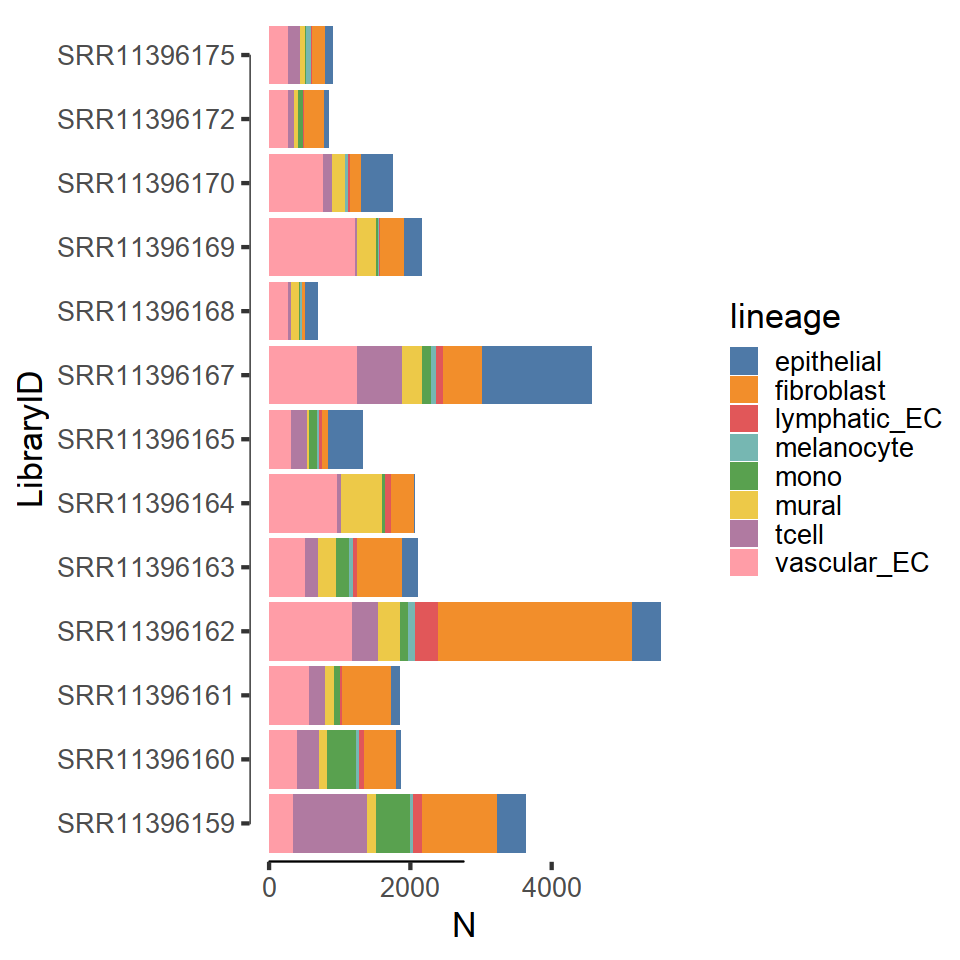

In [103]:
fig.size(8, 8)
data.table(obj$meta_data)[, .N, by = .(lineage, LibraryID)] %>% 
    ggplot(aes(LibraryID, N, fill = lineage)) + 
        geom_bar(stat = 'identity', position = position_stack()) + 
        theme_tufte(base_size = 20) + geom_rangeframe() + 
        scale_fill_tableau('Tableau 10') + 
        coord_flip() + 
        NULL

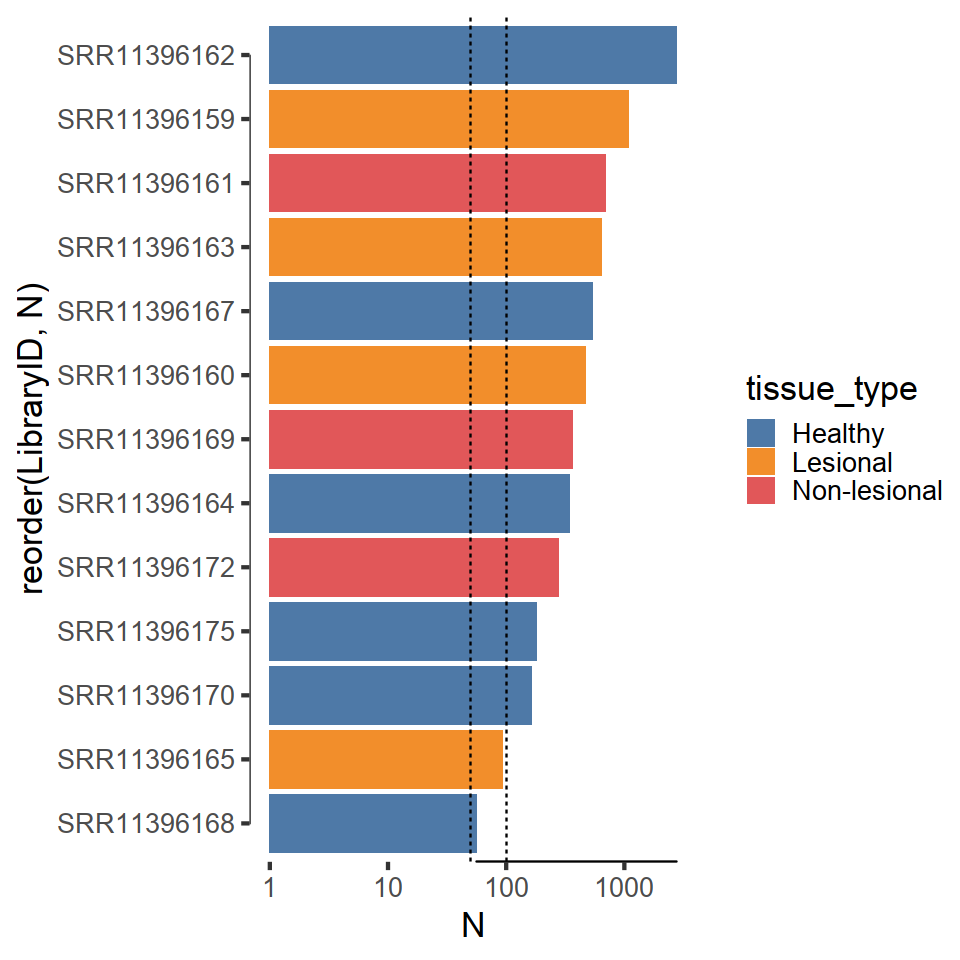

In [105]:
fig.size(8, 8)
data.table(obj$meta_data)[, .N, by = .(lineage, LibraryID, tissue_type)][
    lineage == 'fibroblast'
] %>% 
    ggplot(aes(reorder(LibraryID, N), N, fill = tissue_type)) + 
        geom_bar(stat = 'identity', position = position_stack()) + 
        theme_tufte(base_size = 20) + geom_rangeframe() + 
        scale_fill_tableau('Tableau 10') + 
        coord_flip() + 
        scale_y_log10() + 
        geom_hline(yintercept = c(50, 100), linetype = 2) + 
        NULL


## Presto

In [107]:
## Collapse Counts
pb <- presto::collapse_counts(
    obj$exprs_raw,
    obj$meta_data %>% dplyr::mutate(Cluster = lineage),
    c('LibraryID', 'Cluster'),
    keep_n=TRUE, 
    how='sum',
    min_cells_per_group = 10
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))


In [108]:
## at least 5 counts in 10 samples
genes_test <- rownames(pb$counts_mat)[which(rowSums(pb$counts_mat >= 3) >= 3)]# %>% head(100)
length(genes_test)


[1] 16261

In [110]:
library(lme4)
library(future)
library(furrr)
library(glue)
library(modelr)


In [112]:
devtools::load_all('/data/srlab/ik936/ReproducibleDGE/presto')

Loading presto



In [113]:
## Fit Models
t2 <- system.time({
    suppressWarnings({
        obj$presto <- presto.presto(
            formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+offset(logUMI), 
            design = pb$meta_data, 
            response = pb$counts_mat, 
            size_varname = 'logUMI',
            features = genes_test,
            ncore = 20,
            nsim = 1e3,
            effects_cov = c('Cluster'),
            min_sigma = .5,
            verbose = 1
        ) 
    })
})


CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



In [114]:
## ~20 minutes
t2[['elapsed']] / 60

[1] 19.95887

In [116]:
contrasts_mat <- make_contrast.presto(obj$presto, 'Cluster')
obj$effects <- contrasts.presto(obj$presto, contrasts_mat, one_tailed = TRUE) %>% 
    dplyr::mutate(Cluster = contrast) %>% 
    arrange(pvalue)


In [117]:
obj$effects %>% 
    subset(pvalue < .05 & beta > 0) %>% 
    split(.$Cluster) %>% 
    map(arrange, -zscore) %>% 
    map(head, 5)


$epithelial
# A tibble: 5 x 7
  contrast   feature  beta sigma zscore    pvalue Cluster   
  <chr>      <chr>   <dbl> <dbl>  <dbl>     <dbl> <chr>     
1 epithelial DCD      5.02 0.201   25.0 1.01e-138 epithelial
2 epithelial KRT1     5.00 0.224   22.3 1.63e-110 epithelial
3 epithelial KRTDAP   5.14 0.231   22.2 9.84e-110 epithelial
4 epithelial DMKN     3.96 0.198   20.0 3.91e- 89 epithelial
5 epithelial SBSN     4.77 0.241   19.8 2.49e- 87 epithelial

$fibroblast
# A tibble: 5 x 7
  contrast   feature  beta sigma zscore   pvalue Cluster   
  <chr>      <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>     
1 fibroblast CCDC80   3.34 0.176   19.0 1.97e-80 fibroblast
2 fibroblast DCN      5.05 0.275   18.4 1.31e-75 fibroblast
3 fibroblast CFD      4.65 0.254   18.3 3.71e-75 fibroblast
4 fibroblast COL6A2   3.56 0.196   18.1 9.89e-74 fibroblast
5 fibroblast MFAP4    4.26 0.252   16.9 3.07e-64 fibroblast

$lymphatic_EC
# A tibble: 5 x 7
  contrast     feature  beta sigma zscore    pvalue Cluster     
  <chr>        <chr>   <dbl> <dbl>  <dbl>     <dbl> <chr>       
1 lymphatic_EC TFF3     6.89 0.293   23.5 3.04e-122 lymphatic_EC
2 lymphatic_EC GNG11    3.09 0.158   19.6 9.68e- 86 lymphatic_EC
3 lymphatic_EC AKAP12   3.22 0.180   17.9 4.13e- 72 lymphatic_EC
4 lymphatic_EC CCL21    7.02 0.409   17.2 2.49e- 66 lymphatic_EC
5 lymphatic_EC TFPI     3.78 0.233   16.2 1.83e- 59 lymphatic_EC

$melanocyte
# A tibble: 5 x 7
  contrast   feature  beta sigma zscore   pvalue Cluster   
  <chr>      <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>     
1 melanocyte QPCT     4.11 0.200   20.6 8.16e-95 melanocyte
2 melanocyte MLANA    6.28 0.322   19.5 6.96e-85 melanocyte
3 melanocyte GPM6B    3.88 0.223   17.4 4.62e-68 melanocyte
4 melanocyte SNCA     3.73 0.230   16.2 1.50e-59 melanocyte
5 melanocyte C4orf48  2.51 0.166   15.1 7.50e-52 melanocyte

$mono
# A tibble: 5 x 7
  contrast feature   beta sigma zscore    pvalue Cluster
  <chr>    <chr>    <dbl> <dbl>  <dbl>     <dbl> <chr>  
1 mono     HLA-DRA   4.97 0.186   26.6 1.26e-156 mono   
2 mono     HLA-DPB1  4.45 0.177   25.2 5.42e-140 mono   
3 mono     HLA-DPA1  4.46 0.182   24.6 1.01e-133 mono   
4 mono     CD74      3.95 0.169   23.4 1.58e-121 mono   
5 mono     HLA-DRB1  4.50 0.197   22.8 8.78e-116 mono   

$mural
# A tibble: 5 x 7
  contrast feature  beta sigma zscore   pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>  
1 mural    LBH      3.44 0.174   19.8 1.28e-87 mural  
2 mural    PLN      4.25 0.215   19.8 1.65e-87 mural  
3 mural    ACTA2    5.37 0.288   18.6 6.47e-78 mural  
4 mural    MYH11    3.47 0.187   18.5 8.85e-77 mural  
5 mural    TPM2     4.53 0.256   17.7 2.27e-70 mural  

$tcell
# A tibble: 5 x 7
  contrast feature  beta sigma zscore    pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>     <dbl> <chr>  
1 tcell    CD52     5.10 0.199   25.7 9.41e-146 tcell  
2 tcell    CD69     5.63 0.232   24.3 1.48e-130 tcell  
3 tcell    CORO1A   4.73 0.202   23.5 5.11e-122 tcell  
4 tcell    PTPRC    4.85 0.210   23.1 6.59e-118 tcell  
5 tcell    CD3G     3.95 0.181   21.9 3.06e-106 tcell  

$vascular_EC
# A tibble: 5 x 7
  contrast    feature  beta sigma zscore    pvalue Cluster    
  <chr>       <chr>   <dbl> <dbl>  <dbl>     <dbl> <chr>      
1 vascular_EC RBP7     4.15 0.178   23.3 1.46e-120 vascular_EC
2 vascular_EC PLVAP    4.66 0.214   21.8 1.93e-105 vascular_EC
3 vascular_EC CD34     3.15 0.154   20.4 6.83e- 93 vascular_EC
4 vascular_EC EMCN     3.38 0.172   19.6 3.62e- 86 vascular_EC
5 vascular_EC LIFR     3.42 0.176   19.4 4.61e- 84 vascular_EC

# Vascularization

Unlike the other diseases, eczema has a marked decrease in vascularization! 


Joining, by = "LibraryID"



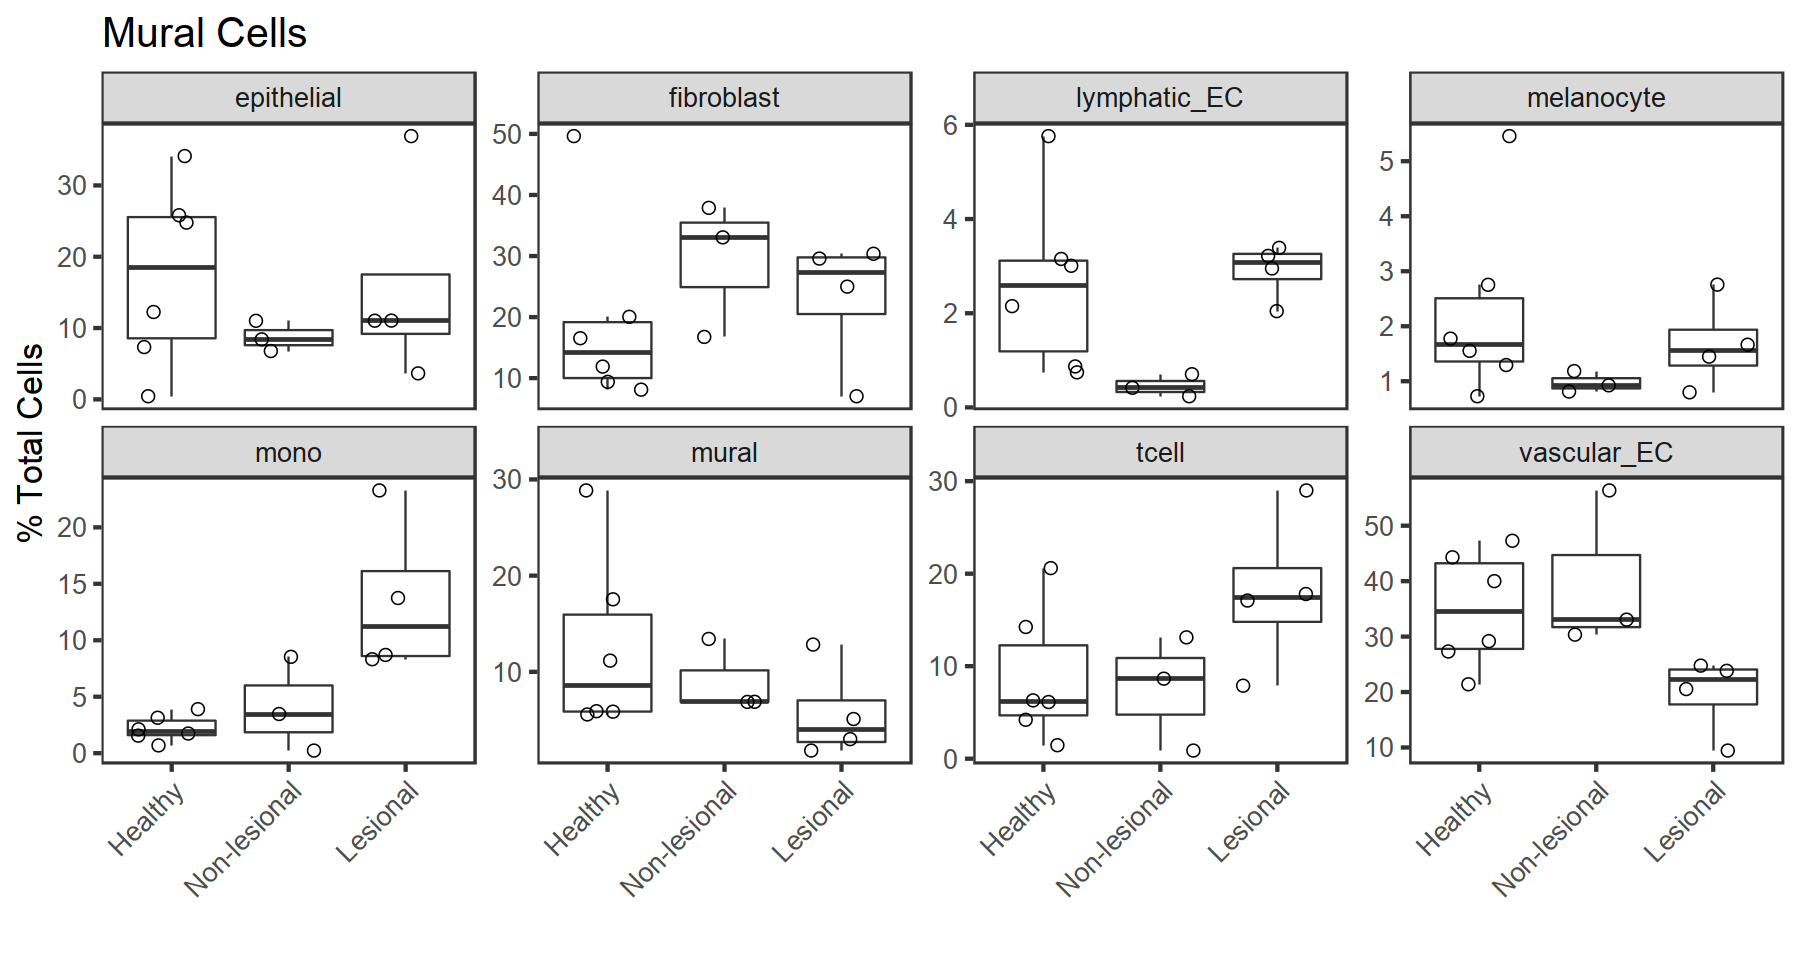

In [5]:
fig.size(8, 15)
obj$meta_data %>% 
    with(prop.table(table(lineage, LibraryID), 2)) %>% 
    data.table() %>% 
    inner_join(
        obj$meta_data %>% 
            dplyr::select(LibraryID, disease, tissue_type) %>% 
            unique()    
    ) %>% 
    dplyr::mutate(tissue_type = factor(tissue_type, c('Healthy', 'Non-lesional', 'Lesional'))) %>% 
    ggplot(aes(tissue_type, 100 * N)) +
        geom_boxplot(outlier.shape = NA) + 
        geom_jitter(height = 0, width = .3, size = 3, shape = 21) + 
        theme_test(base_size = 20) + 
        facet_wrap(~lineage, scales = 'free_y', nrow = 2) + 
        labs(x = '', y = '% Total Cells', title = 'Mural Cells') + 
#         coord_flip() + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
        NULL
    

In [8]:
head(obj$meta_data)

CellID                       LibraryID   nGene nUMI percent_mito
1 AAACCTGCAACAACCT_SRR11396159 SRR11396159  810  1404 0.03846154  
2 AAACCTGGTAGAGTGC_SRR11396159 SRR11396159 1244  2650 0.06452830  
3 AAACCTGTCCTTTCGG_SRR11396159 SRR11396159  670  1156 0.10207612  
4 AAACCTGTCGGAAATA_SRR11396159 SRR11396159 1627  4193 0.05795373  
5 AAACGGGAGTTTCCTT_SRR11396159 SRR11396159  954  1709 0.02867174  
6 AAACGGGCAAGGTGTG_SRR11396159 SRR11396159  675  1672 0.13696172  
  geo_accession_exp title disease           frozen_vs_fresh tissue_type
1 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
2 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
3 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
4 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
5 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
6 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
  scDblFinder.weighted scDblFinder.ratio scDblFinder.score scDblFinder.class
1 0.04719531           0.05              0.04719531        singlet          
2 0.26460159           0.25              0.26460159        singlet          
3 0.00000000           0.00              0.00000000        singlet          
4 0.15361019           0.15              0.15361019        singlet          
5 0.00000000           0.00              0.00000000        singlet          
6 0.04753962           0.05              0.04753962        singlet          
  weight lineage     percent_cd45 percent_cd45_beta
1 1      fibroblast  42.74305     1                
2 1      fibroblast  42.74305     1                
3 1      vascular_EC 42.74305     1                
4 1      mono        42.74305     1                
5 1      mono        42.74305     1                
6 1      fibroblast  42.74305     1

In [12]:
table(obj$meta_data$lineage)


  epithelial   fibroblast lymphatic_EC   melanocyte         mono        mural 
        4325         7644          817          440         1715         2528 
       tcell  vascular_EC 
        3460         8336 

In [20]:
# res <- glmer(
#     Cluster ~ 1 + Response + (1|LibraryID),
#     obj$meta_data %>% 
#         dplyr::mutate(Response = case_when(
#             tissue_type == 'Lesional' ~ 1L,
#             TRUE ~ 0L
#         )) %>% 
#         dplyr::mutate(Cluster = case_when(
#             lineage %in% c('vascular_EC') ~ 'EC',
# #             lineage == 'mural' ~ 'mural', 
#             TRUE ~ 'other'
#         )),
#     'binomial'
# )


In [ ]:
res

# Inflam Status

In [277]:
# data.table(obj$meta_data)[, N := sum(lineage %in% c('tcell')) / .N, by = LibraryID][]

In [6]:
unique(obj$meta_data$lineage)

[1] "fibroblast"   "vascular_EC"  "mono"         "tcell"        "epithelial"  
[6] "mural"        "lymphatic_EC" "melanocyte"

Joining, by = "LibraryID"



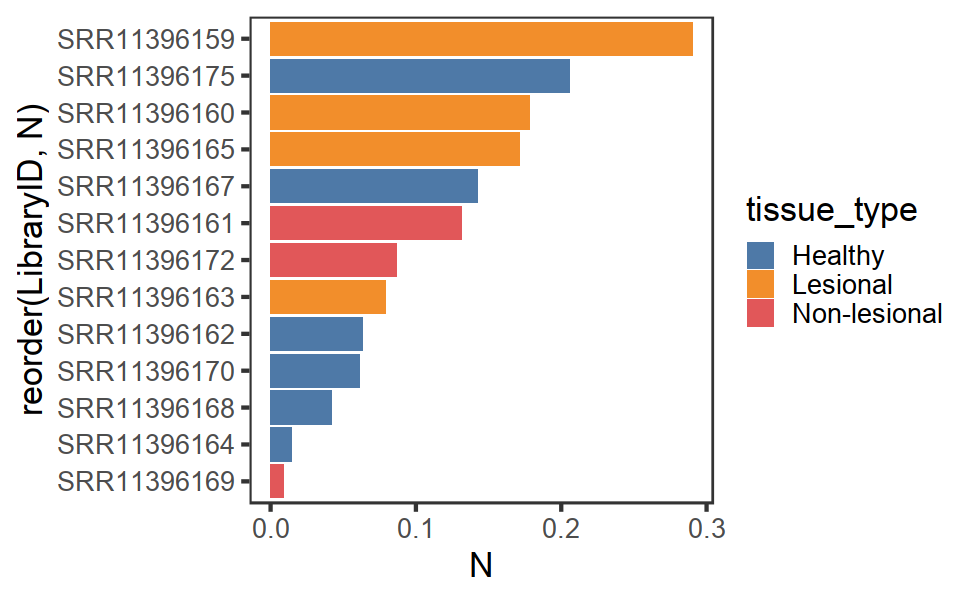

In [7]:
fig.size(5, 8)
data.table(obj$meta_data)[, .(N = sum(lineage %in% c('tcell')) / .N), by = LibraryID][] %>% 
# data.table(obj$meta_data)[, .(N = sum(lineage %in% c('tcell', 'mono')) / .N), by = LibraryID][] %>% 
    inner_join(
        obj$meta_data %>% 
            dplyr::select(LibraryID, disease, tissue_type) %>% 
            unique()    
    ) %>% 
    ggplot(aes(reorder(LibraryID, N), N, fill = tissue_type)) +
        geom_bar(stat = 'identity') + 
        coord_flip() + 
        scale_fill_tableau() + 
        theme_test(base_size = 20)


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



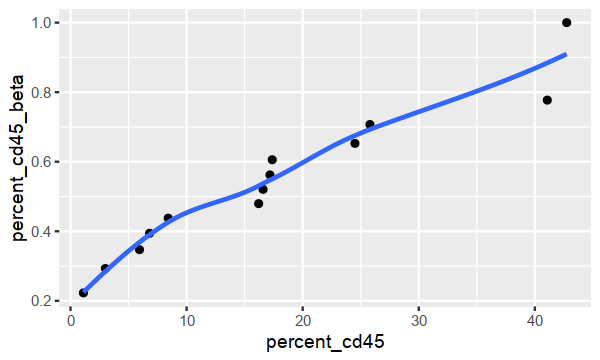

In [14]:
fig.size(3, 5)
plt_df <- data.table(obj$meta_data)[, .(percent_cd45 = 100 * sum(lineage %in% c('tcell', 'mono')) / .N), by = LibraryID][] %>% 
    dplyr::mutate(percent_cd45_beta = qbeta(rank(percent_cd45) / n(), 3, 3)) 

plt_df %>% 
    ggplot(aes(percent_cd45, percent_cd45_beta)) + 
        geom_point() + 
        scale_color_tableau() + 
        geom_smooth(se = FALSE)


In [18]:
obj$meta_data <- obj$meta_data %>% 
    dplyr::select(!matches('InflamScore_beta|percent_cd45')) %>% 
    left_join(dplyr::select(plt_df, LibraryID, percent_cd45, percent_cd45_beta)) 


Joining, by = "LibraryID"



# Clean up stray cells

In [186]:
m_use <- obj$meta_data %>% 
    subset(lineage == 'fibroblast') 


In [187]:
obj2 <- create_object(
    obj$exprs_raw[, m_use$CellID], 
    m_use, 
    min_ngene=500, 
    max_mt=0.2
)


start filter

start normalization

start vargenes

start pca



## UMAP

In [188]:
umap_after_fname <- tempfile(tmpdir = '/data/srlab/ik936/Roche/data/cache', pattern = 'umap_')
umap_res <- do_umap(obj2$V, umap_after_fname)


Warning message:
“invalid uid value replaced by that for user 'nobody'”


In [189]:
obj2$umap_after_fname = umap_after_fname
obj2$umap_after = umap_res$embedding
obj2$adj_after = umap_res$adj
obj2$knn_after = umap_res$knn


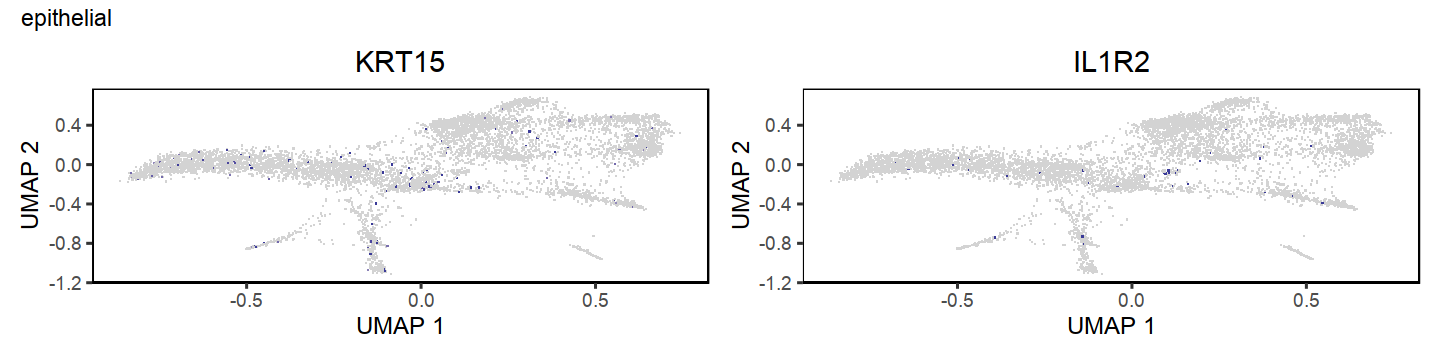

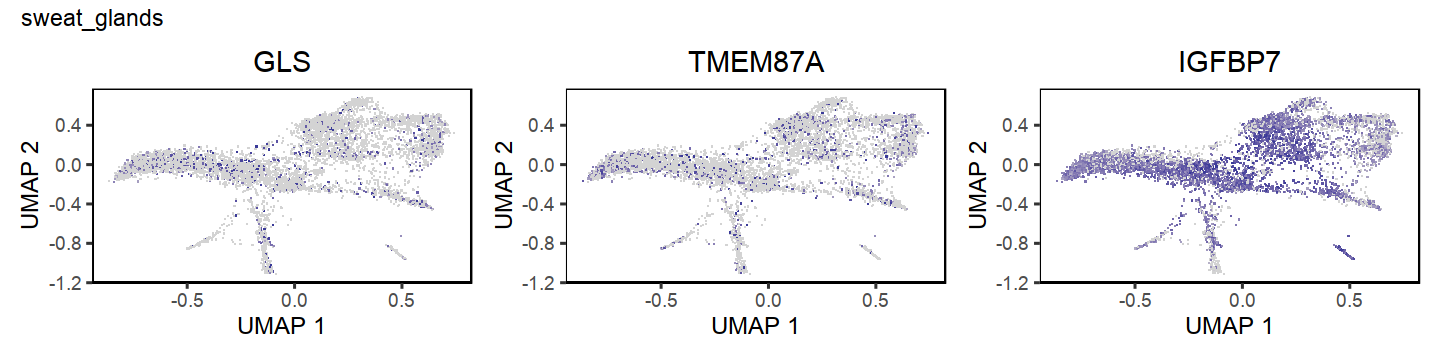

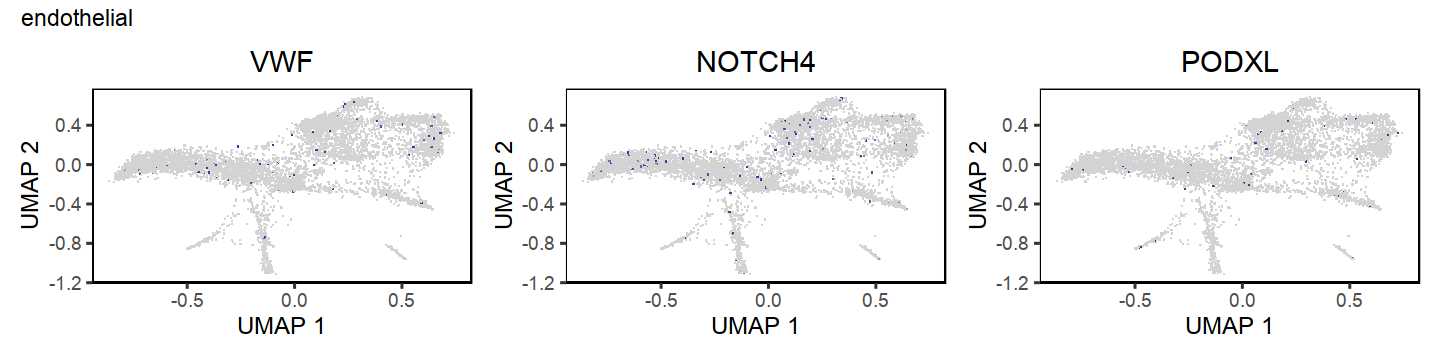

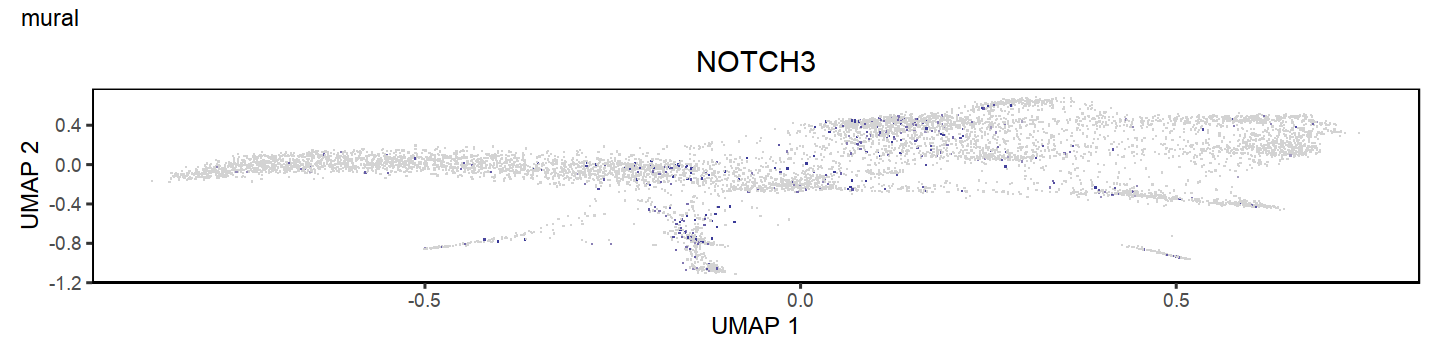

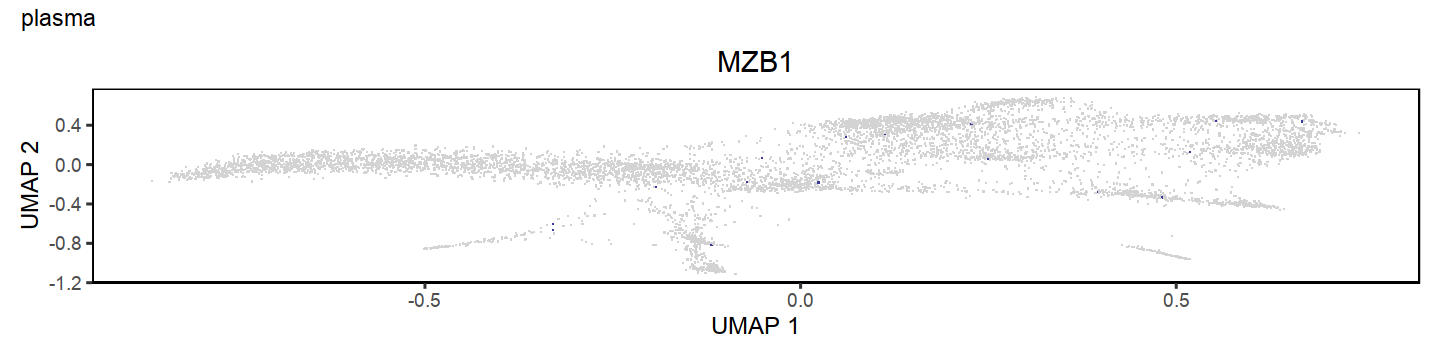

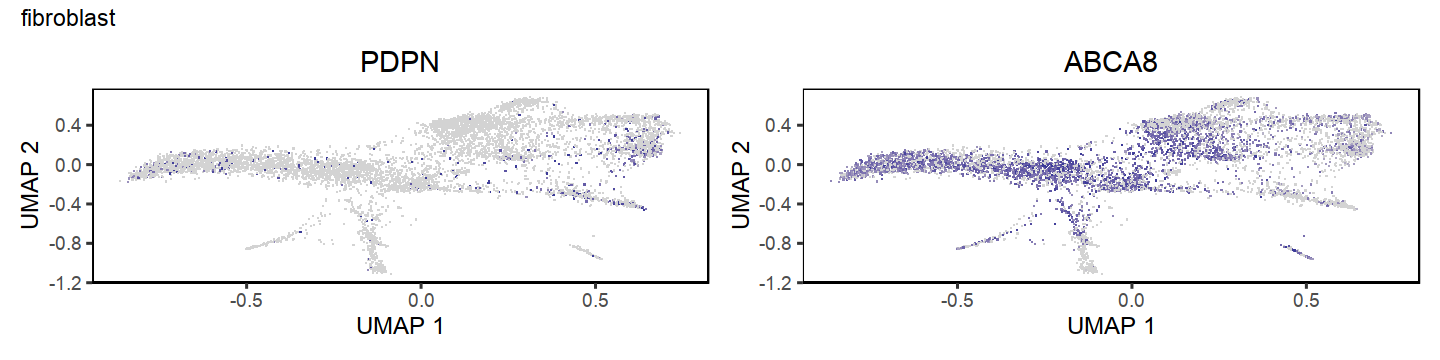

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]


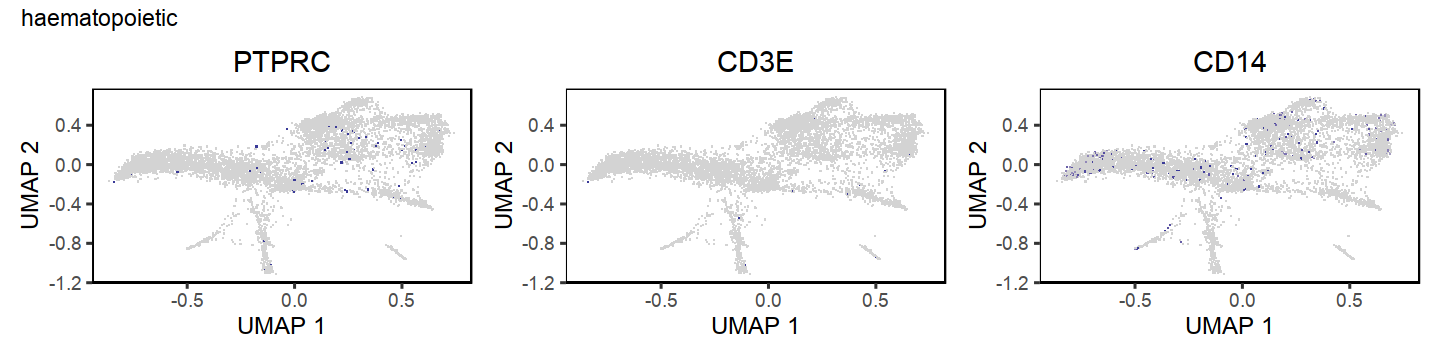

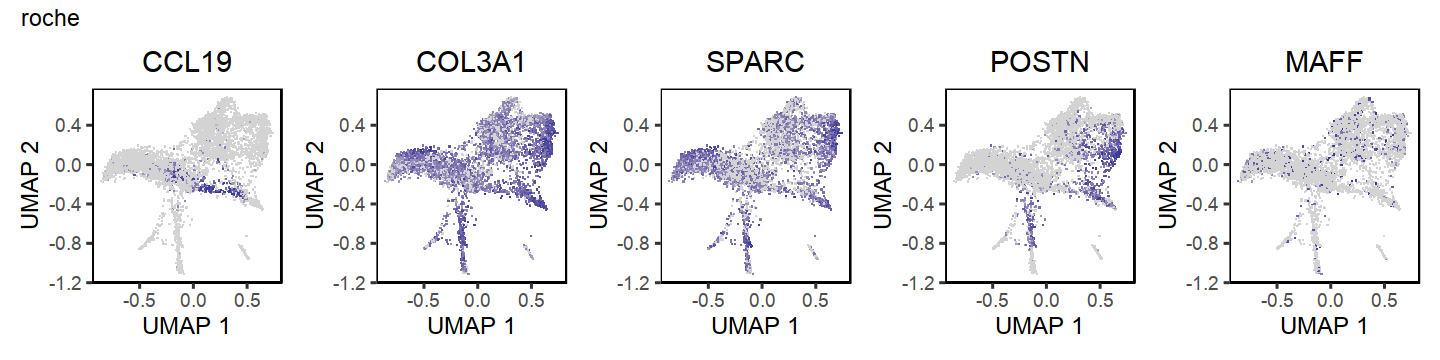

In [191]:
fig.size(3, 12)
with(obj2, {
    lapply(names(lineage_markers), function(group) {
        plotFeatures(exprs_norm, umap_after,
                     intersect(lineage_markers[[group]], row.names(exprs_norm)), 
                     qhi = .99, no_guide = TRUE) + 
            plot_annotation(title = group)
    })    
})


## Louvain

In [192]:
future::plan(multiprocess)

set.seed(3)
t_cluster <- system.time({
    obj2 <- do_cluster(
#         obj, 'adj', c(.1, .3, .5, .8, 1.0, 1.2, 1.5, 1.8, 2.1),
        obj2, 'adj_after', c(.1, .3, .5),
        append_cols = FALSE, 
        force_snn = TRUE,
        slot_name = 'clusters_df', 
        do_weights = FALSE,
#         n.start = 10, n.iter = 20, 
        algorithm = 1 ## Louvain
#         algorithm = 2 ## Multi-level refinement Louvain
#         algorithm = 3 ## SLM
#         algorithm = 4 ## Leiden
    )
#     obj <- do_cluster(obj, c(.1, .3, .5, .8, 1.2, 1.5))
})


0.1

0.3

0.5

New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3

finished Louvain



Warning message:
“Ignoring unknown parameters: segment.size”
Warning message:
“Ignoring unknown parameters: label.size, segment.size”


[[1]]


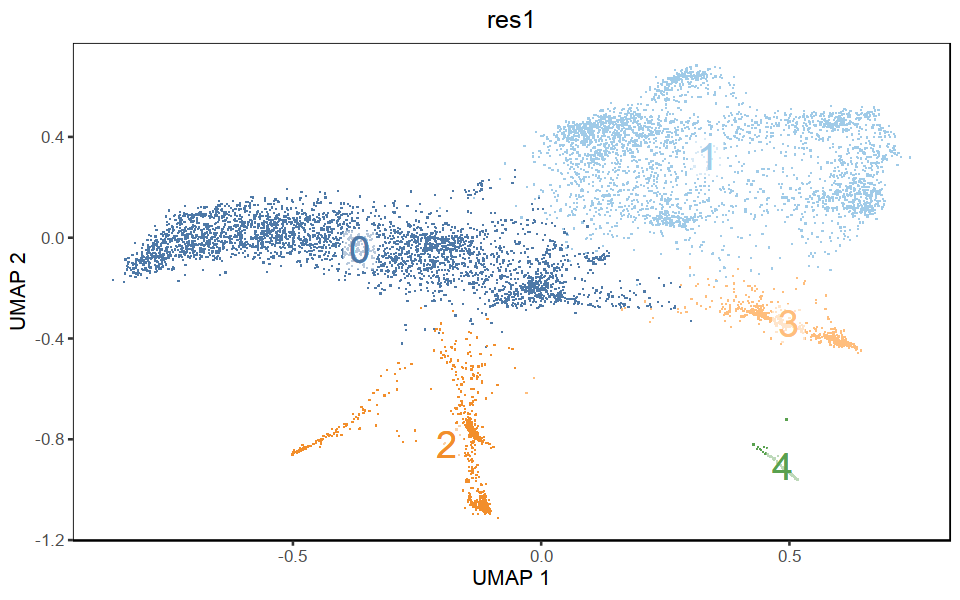

In [193]:
fig.size(5, 8)
plot_clusters(obj2, 'umap_after', 'res1')


In [202]:
# mres <- wilcoxauc(obj2$exprs_norm, obj2$clusters_df$res1)

# mres %>% 
#     subset(auc > 0.5) %>% 
#     subset(group == '3') %>% 
#     arrange(-auc) %>% 
#     head(20)


# Fibroblasts

In [204]:
idx_fib <- which(!obj2$clusters_df$res1 %in% c('4')) ## stray cells

fib <- create_object(
    obj2$exprs_raw[, idx_fib], 
    obj2$meta_data[idx_fib, ], 
    min_ngene=500, 
    max_mt=0.2
)


start filter

start normalization

start vargenes

start pca



# Symphony mapping

## Human ref object

In [3]:
obj_tissues <- readRDS('/data/srlab/ik936/Roche/data/cache/obj_fibroblasts.rds')

In [4]:
ref_obj <- .buildReferenceFromHarmonyObj(
    obj_tissues$R, 
    t(obj_tissues$V), 
    obj_tissues$Z_corr, 
    obj_tissues$betas, 
    cbind(obj_tissues$meta_data, obj_tissues$clusters_df), 
    obj_tissues$vargenes_means_sds, 
    obj_tissues$loadings
)


## Map fibroblasts

In [5]:
reduce <- purrr::reduce

In [8]:
query_obj <- .mapQuery(
    fib$exprs_raw, 
    fib$meta_data,
    ref_obj, 
#     vars = 'LibraryID', # query batch variables to harmonize over
    vars = NULL, # query batch variables to harmonize over
    do_normalize = TRUE
)
    

In [9]:
query_obj$exprs_raw <- fib$exprs_raw

## UMAP

In [10]:
uwot_obj <- uwot::load_uwot(obj_tissues$umap_after_fname)
query_obj$U <- umap_query <- uwot::umap_transform(t(singlecellmethods:::cosine_normalize_cpp(query_obj$Z, 2)), uwot_obj)


### where do they land? 

In [ ]:
head(query_obj$meta_data)

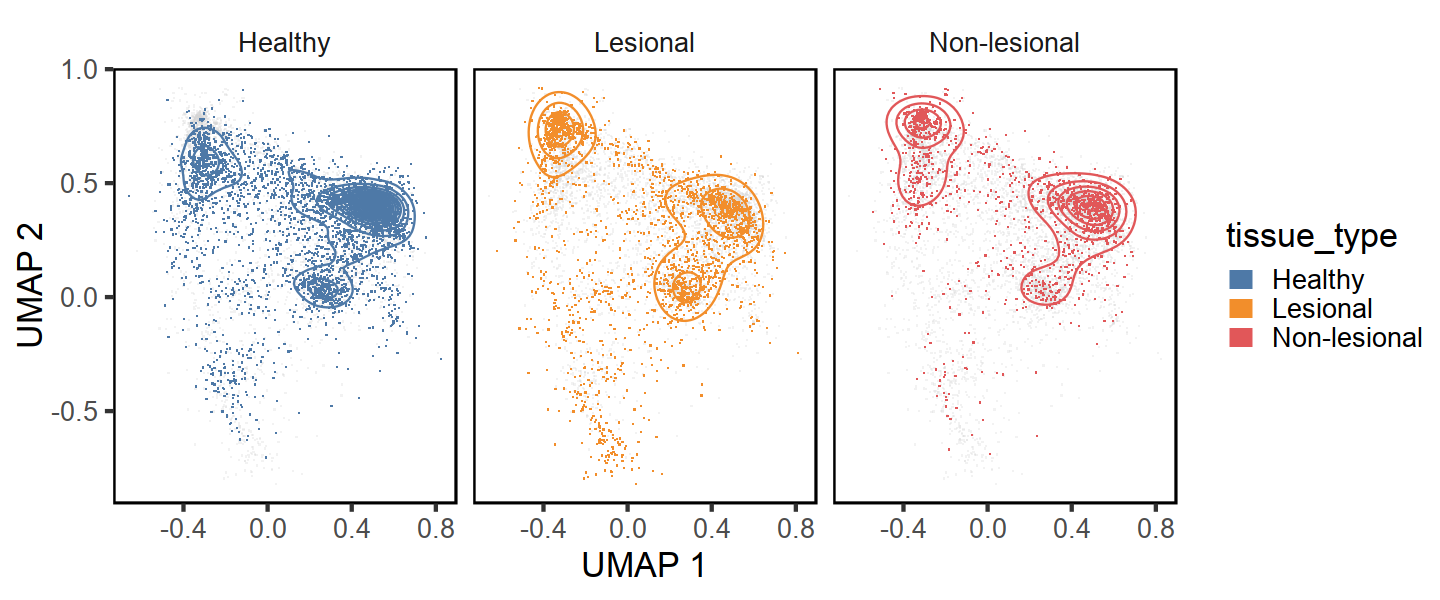

In [12]:
fig.size(5, 12)
do_scatter(
    query_obj$U, 
    query_obj$meta_data,
    'tissue_type', quo(tissue_type), nrow = 1,  
    palette_use = tableau_color_pal('Tableau 10')(10), 
    do_density = TRUE, 
    do_labels = FALSE, no_guides = FALSE, base_size = 20
)


### ref + query UMAP

In [13]:
## Join the ref and query datasets
m <- list(
    ref = dplyr::select(obj_tissues$meta_data, LibraryID, Cluster),
    query = dplyr::select(query_obj$meta_data, LibraryID, tissue_type)
) %>% 
    bind_rows(.id = 'species')


U <- rbind(obj_tissues$umap_after, query_obj$U)


Warning message:
“Removed 79968 rows containing missing values (geom_point).”


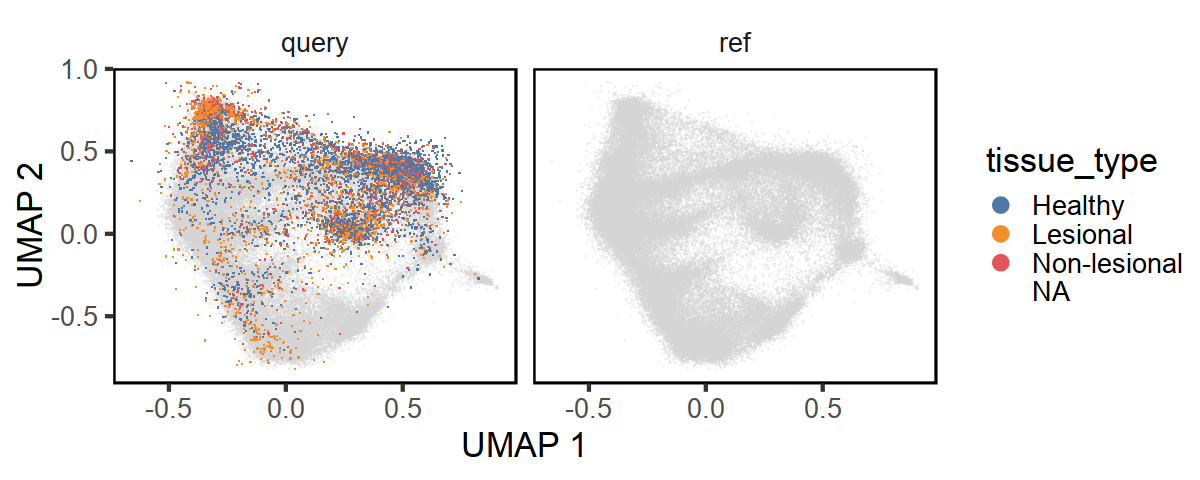

In [14]:
fig.size(4, 10)
do_scatter(
    U, m,
    'tissue_type', quo(species), nrow = 1, 
    palette_use = tableau_color_pal('Tableau 10')(10), 
    do_labels = FALSE, no_guides = FALSE, base_size = 20
)


## KNN prediction

In [15]:
library(RANN)
knn <- nn2(t(obj_tissues$Z_cos), t(singlecellmethods:::cosine_normalize_cpp(query_obj$Z, 2)), k = 10, eps = 0)


In [16]:
library(modelr)
probs <- as.numeric(matrix(t(prop.table(exp(-knn$nn.dists / .1), 1)), ncol = 1))
## mm by hs matrix 
knn_dgc <- sparseMatrix(
    i = as.numeric(rep(seq_len(nrow(knn$nn.idx)), each = ncol(knn$nn.idx))), 
    j = as.numeric(matrix(t(knn$nn.idx), ncol = 1)), 
    x = probs ## distance to probability
)

In [17]:
idx_min <- min(as.integer(knn$nn.idx))
idx_max <- max(as.integer(knn$nn.idx))

cluster_design <- as(as.matrix(model_matrix(obj_tissues$meta_data[1:idx_max, ], ~ 0 + Cluster)), 'dgCMatrix')
class_pred_probs <- knn_dgc %*% cluster_design
query_obj$meta_data$Cluster <- paste0('C', gsub('Cluster', '', colnames(cluster_design)))[apply(class_pred_probs, 1, which.max)]
# query_obj$meta_data$Cluster <- paste0('C', gsub('Cluster', '', colnames(cluster_design)))[apply(class_pred_probs, 1, which.max)]


In [18]:
head(query_obj$meta_data)

CellID                       LibraryID   nGene nUMI percent_mito
1 AAACCTGCAACAACCT_SRR11396159 SRR11396159  810  1404 0.03846154  
2 AAACCTGGTAGAGTGC_SRR11396159 SRR11396159 1244  2650 0.06452830  
3 AAACGGGCAAGGTGTG_SRR11396159 SRR11396159  675  1672 0.13696172  
4 AAACGGGCAATGGTCT_SRR11396159 SRR11396159 1257  2809 0.03987184  
5 AAAGATGCAAACCCAT_SRR11396159 SRR11396159 1712  3816 0.02175052  
6 AAAGATGCATCATCCC_SRR11396159 SRR11396159 1746  3695 0.02760487  
  geo_accession_exp title disease           frozen_vs_fresh tissue_type
1 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
2 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
3 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
4 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
5 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
6 GSM4430459        S1_LS Atopic dermatitis Frozen          Lesional   
  scDblFinder.weighted scDblFinder.ratio scDblFinder.score scDblFinder.class
1 0.04719531           0.05              0.04719531        singlet          
2 0.26460159           0.25              0.26460159        singlet          
3 0.04753962           0.05              0.04753962        singlet          
4 0.09326680           0.10              0.09326680        singlet          
5 0.05097778           0.05              0.05097778        singlet          
6 0.25490799           0.25              0.25490799        singlet          
  weight lineage    InflamScore_beta Cluster
1 1      fibroblast 1                C1     
2 1      fibroblast 1                C9     
3 1      fibroblast 1                C7     
4 1      fibroblast 1                C9     
5 1      fibroblast 1                C5     
6 1      fibroblast 1                C9

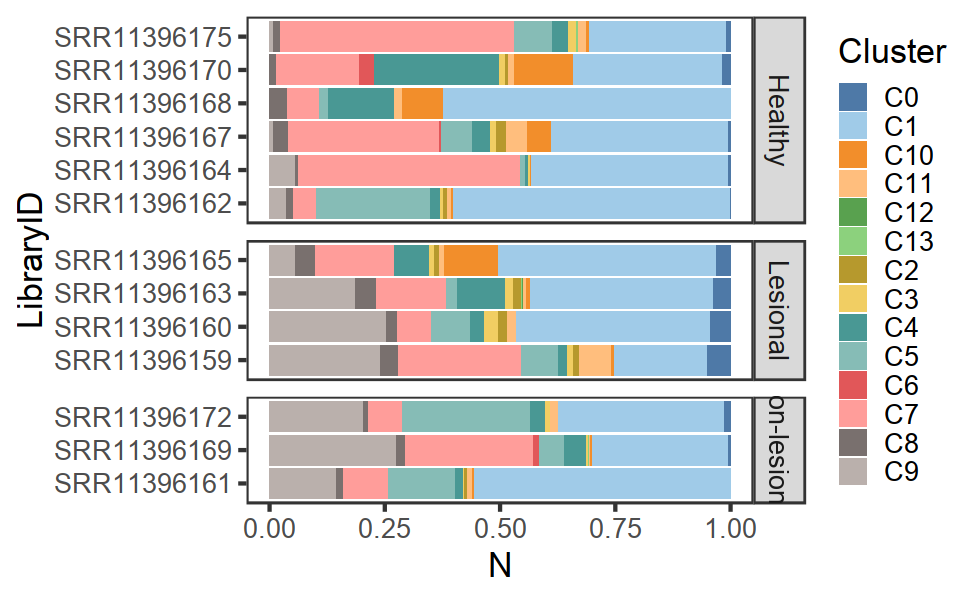

In [19]:
fig.size(5, 8)
query_obj$meta_data %>% 
    with(table(LibraryID, Cluster, tissue_type)) %>% 
    prop.table(1) %>% 
    data.table() %>% 
    subset(N > 0) %>% 
    ggplot(aes(LibraryID, N, fill = Cluster)) + 
        geom_bar(stat = 'identity') + 
        scale_fill_tableau('Tableau 20') + 
        theme_test(base_size = 20) + 
        coord_flip() + 
        facet_grid(tissue_type~., scales = 'free', space = 'free') + 
        NULL


## MASC

In [20]:
nsim <- 1e3
foo <- function(cluster_test, data_df) {
    message(cluster_test)
    data_use <- data_df %>% 
        dplyr::mutate(Response = case_when(
            Cluster == cluster_test ~ 1L,
            TRUE ~ 0L
        ))
    
    tryCatch({
        model <- glmer(
            formula = Response ~ 1 + percent_cd45_beta + (scDblFinder.score+percent_mito||LibraryID), 
            data = data_use, 
            family = 'binomial'
        )
        tibble(
            Cluster = cluster_test,
            Ncells = sum(data_use$Response == 1L),
            beta = fixef(model)[['percent_cd45_beta']] / log(2),
            sigma = sqrt(vcov(model)['percent_cd45_beta', 'percent_cd45_beta']) / log(2)
        ) %>% 
        dplyr::mutate(zscore = beta / sigma) %>% 
        dplyr::mutate(pvalue = 2 * pnorm(-abs(zscore))) %>% 
        return()

    }, error = function(e) {
        print(e)
        tibble(
            Cluster = cluster_test,
            Ncells = sum(data_use$Response == 1L),
            beta = NA,
            sigma = NA
        ) %>% 
        return()

    })    
}

In [24]:
library(lme4)
query_obj <- fib$query
clusters <- unique(query_obj$meta_data$Cluster)
data_df <- query_obj$meta_data %>% 
    dplyr::mutate(percent_mito = scale(percent_mito)) %>% 
    ## Take updated scores from obj$meta_data 
    dplyr::select(-matches('InflamScore_|percent_cd45')) %>% 
    left_join(unique(dplyr::select(obj$meta_data, LibraryID, percent_cd45_beta)))

res <- map(clusters, foo, data_df)
names(res) <- clusters
res <- bind_rows(res, .id = 'Cluster')


Joining, by = "LibraryID"

C1

C9

C7

C5

C8

C11

C4

C0

C2

C3

C10

C6

boundary (singular) fit: see ?isSingular

C13

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
C12

boundary (singular) fit: see ?isSingular



In [25]:
masc_res <- res %>% 
#     subset(grpvar == 'Statusdss') %>%
    dplyr::arrange(-beta) %>% 
    dplyr::mutate(Z = beta / sigma) %>% 
    dplyr::mutate(pval = 2 * (1 - pnorm(abs(beta / sigma)))) %>% 
    dplyr::mutate(fdr = p.adjust(pval, 'BH')) %>% 
    subset(pvalue < 1)


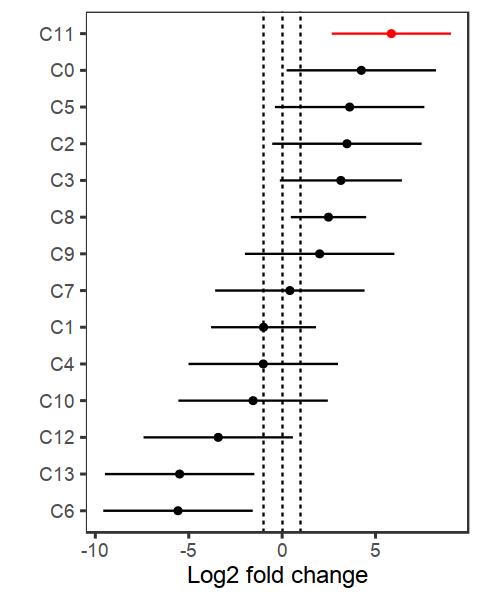

In [26]:
# cluster_levels <- data.table(bind_rows(obj$masc))[, .(Z = mean(beta)), by = Cluster][order(-Z), Cluster]
cluster_levels <- data.table(masc_res)[, .(Z = mean(beta)), by = Cluster][order(-Z), Cluster]

fig.size(5, 4)
# data.table(obj$masc$pertissue_sc)[, sum(beta > 0), by = .(Cluster)][V1 >= 2][, V1 := NULL][] %>% 
#     inner_join(obj$masc$pertissue_sc) %>%
masc_res %>% 
    dplyr::mutate(Cluster = factor(Cluster, rev(cluster_levels))) %>% 
    dplyr::mutate(sigma = pmin(sigma, 2)) %>% 
#     subset(Cluster %in% c(=)) %>% 
#     dplyr::mutate(
#         q025 = pmax(-1.96 * sigma + beta, -5),
#         q975 = pmin(1.96 * sigma + beta, 5)
#     ) %>% 
    ggplot(aes(Cluster, beta, color = fdr < .05)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = beta - 2 * sigma, ymax = beta + 2 * sigma), width = 0) + 
#         geom_errorbar(aes(ymin = q025, ymax = q975), width = 0) + 
        coord_flip() + 
        theme_test(base_size = 14) + 
#         scale_color_tableau() + 
        scale_color_manual(values = c('black', 'red')) + 
#         facet_grid(Cluster~., space = 'free', scales = 'free') + 
        geom_hline(yintercept = c(-1, 0, 1), linetype = 2) + 
        labs(x = '', y = 'Log2 fold change') + 
        guides(color = FALSE) + 
#         scale_y_continuous(breaks = seq(-5, 5)) + 
#         ylim(-5, 5) + 
        NULL


In [27]:
head(masc_res)

Cluster Ncells beta     sigma    zscore   pvalue       Z        pval        
1 C11      158   5.846603 1.596051 3.663169 0.0002491144 3.663169 0.0002491144
2 C0       130   4.238841 2.206991 1.920643 0.0547767415 1.920643 0.0547767415
3 C5      1063   3.612982 2.898313 1.246581 0.2125512051 1.246581 0.2125512051
4 C2        78   3.469626 2.000462 1.734412 0.0828450032 1.734412 0.0828450032
5 C3        72   3.143674 1.633656 1.924318 0.0543147462 1.924318 0.0543147462
6 C8       166   2.481875 1.008596 2.460723 0.0138657271 2.460723 0.0138657271
  fdr        
1 0.003487602
2 0.191718595
3 0.495952812
4 0.231966009
5 0.191718595
6 0.097060089

In [28]:
fib$masc <- masc_res

In [28]:
fib$masc <- masc_res

### with tissue_type covar

In [34]:
nsim <- 1e3
foo <- function(cluster_test, data_df) {
    message(cluster_test)
    data_use <- data_df %>% 
        dplyr::mutate(Response = case_when(
            Cluster == cluster_test ~ 1L,
            TRUE ~ 0L
        ))
    
    tryCatch({
        model <- glmer(
            formula = Response ~ 1 + percent_cd45_beta + tissue_type + (scDblFinder.score+percent_mito||LibraryID), 
            data = data_use, 
            family = 'binomial'
        )
        tibble(
            Cluster = cluster_test,
            Ncells = sum(data_use$Response == 1L),
            beta = fixef(model)[['percent_cd45_beta']] / log(2),
            sigma = sqrt(vcov(model)['percent_cd45_beta', 'percent_cd45_beta']) / log(2)
        ) %>% 
        dplyr::mutate(zscore = beta / sigma) %>% 
        dplyr::mutate(pvalue = 2 * pnorm(-abs(zscore))) %>% 
        return()

    }, error = function(e) {
        print(e)
        tibble(
            Cluster = cluster_test,
            Ncells = sum(data_use$Response == 1L),
            beta = NA,
            sigma = NA
        ) %>% 
        return()

    })    
}

In [35]:
library(lme4)
query_obj <- fib$query
clusters <- unique(query_obj$meta_data$Cluster)
data_df <- query_obj$meta_data %>% 
    dplyr::mutate(percent_mito = scale(percent_mito)) %>% 
    ## Take updated scores from obj$meta_data 
    dplyr::select(-matches('InflamScore_|percent_cd45')) %>% 
    left_join(unique(dplyr::select(obj$meta_data, LibraryID, percent_cd45_beta)))

res <- map(clusters, foo, data_df)
names(res) <- clusters
res <- bind_rows(res, .id = 'Cluster')



Joining, by = "LibraryID"

C1

C9

C7

C5

C8

boundary (singular) fit: see ?isSingular

C11

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0213915 (tol = 0.002, component 1)”
C4

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0139793 (tol = 0.002, component 1)”
C0

boundary (singular) fit: see ?isSingular

C2

C3

C10

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0194839 (tol = 0.002, component 1)”
C6

C13

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
C12

boundary (singular) fit: see ?isSingul

In [36]:
masc_res_2 <- res %>% 
    dplyr::arrange(-beta) %>% 
    dplyr::mutate(Z = beta / sigma) %>% 
    dplyr::mutate(pval = 2 * (1 - pnorm(abs(beta / sigma)))) %>% 
    dplyr::mutate(fdr = p.adjust(pval, 'BH')) %>% 
    subset(pvalue < 1)


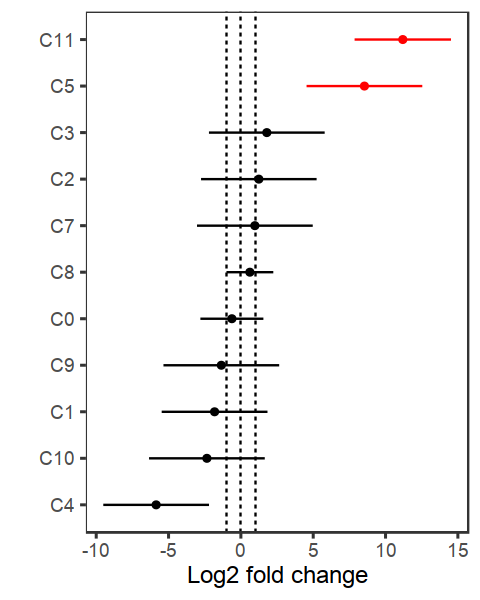

In [41]:
fig.size(5, 4)
cluster_levels <- data.table(masc_res_2)[, .(Z = mean(beta)), by = Cluster][order(-Z), Cluster]
masc_res_2 %>% 
    subset(!Cluster %in% c('C12', 'C6', 'C13')) %>% 
    dplyr::mutate(Cluster = factor(Cluster, rev(cluster_levels))) %>% 
    dplyr::mutate(sigma = pmin(sigma, 2)) %>% 
    ggplot(aes(Cluster, beta, color = fdr < .05 & beta > 0)) + 
        geom_point() + 
        geom_errorbar(aes(ymin = beta - 2 * sigma, ymax = beta + 2 * sigma), width = 0) + 
        coord_flip() + 
        theme_test(base_size = 14) + 
        scale_color_manual(values = c('black', 'red')) + 
        geom_hline(yintercept = c(-1, 0, 1), linetype = 2) + 
        labs(x = '', y = 'Log2 fold change') + 
        guides(color = FALSE) + 
        NULL


In [42]:
fib$masc_2 <- masc_res_2

# Presto

## Collapse

In [31]:
## Collapse Counts
pb <- presto::collapse_counts(
    query_obj$exprs_raw,
    query_obj$meta_data,
    c('LibraryID', 'Cluster'),
    keep_n=TRUE, 
    how='sum',
    min_cells_per_group = 10
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))


## Train models

In [32]:
## at least 5 counts in 10 samples
genes_test <- rownames(pb$counts_mat)[which(rowSums(pb$counts_mat >= 3) >= 3)]# %>% head(100)
length(genes_test)


[1] 13667

In [34]:
library(lme4)
library(future)
library(furrr)
library(glue)
library(modelr)


In [36]:
devtools::load_all('/data/srlab/ik936/ReproducibleDGE/presto')

Loading presto



In [37]:
## Fit Models
t2 <- system.time({
    suppressWarnings({
        query_obj$presto <- presto.presto(
#             formula = y~1+InflamScore_beta+(1|Cluster)+(1|LibraryID/Cluster)+(1|Tissue/Cluster)+offset(logUMI), 
            formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+offset(logUMI), 
            design = pb$meta_data, 
            response = pb$counts_mat, 
            size_varname = 'logUMI',
            features = genes_test,
            ncore = 20,
            nsim = 1e3,
            effects_cov = c('Cluster'),
            min_sigma = .5,
            verbose = 1
        ) 
    })
})


CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



In [38]:
## ~20 minutes
t2[['elapsed']] / 60

[1] 13.47867

## Get effects

In [18]:
contrasts_mat <- make_contrast.presto(query_obj$presto, 'Cluster')
effects <- contrasts.presto(query_obj$presto, contrasts_mat, one_tailed = FALSE) %>% 
    dplyr::mutate(Cluster = contrast) %>% 
    arrange(pvalue)


In [19]:
effects %>% 
    subset(pvalue < .05 & beta > 0) %>% 
    split(.$Cluster) %>% 
    map(arrange, -zscore) %>% 
    map(head, 5)


$C0
# A tibble: 5 x 7
  contrast feature    beta sigma zscore        pvalue Cluster
  <chr>    <chr>     <dbl> <dbl>  <dbl>         <dbl> <chr>  
1 C0       TNC        2.38 0.408   5.84 0.00000000520 C0     
2 C0       SERPINE2   1.44 0.284   5.07 0.000000388   C0     
3 C0       IL32       1.24 0.285   4.34 0.0000142     C0     
4 C0       TNFRSF12A  1.07 0.266   4.03 0.0000555     C0     
5 C0       BATF3      1.54 0.413   3.74 0.000185      C0     

$C1
# A tibble: 5 x 7
  contrast feature   beta sigma zscore       pvalue Cluster
  <chr>    <chr>    <dbl> <dbl>  <dbl>        <dbl> <chr>  
1 C1       KRT14    0.991 0.177   5.61 0.0000000199 C1     
2 C1       ANKRD36C 0.972 0.199   4.87 0.00000110   C1     
3 C1       HOXB3    0.779 0.172   4.53 0.00000576   C1     
4 C1       ADAM33   0.969 0.223   4.35 0.0000139    C1     
5 C1       ABCA6    0.879 0.207   4.24 0.0000219    C1     

$C10
# A tibble: 5 x 7
  contrast feature  beta sigma zscore       pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>        <dbl> <chr>  
1 C10      TFAP2C   1.81 0.324   5.58 0.0000000242 C10    
2 C10      RORB     1.09 0.218   5.02 0.000000522  C10    
3 C10      BMP4     1.95 0.389   5.01 0.000000555  C10    
4 C10      BCL11A   1.37 0.277   4.96 0.000000704  C10    
5 C10      SAT1     1.15 0.233   4.93 0.000000824  C10    

$C11
# A tibble: 5 x 7
  contrast feature  beta sigma zscore   pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>  
1 C11      IL32     1.89 0.274   6.90 5.35e-12 C11    
2 C11      RBP5     1.92 0.351   5.48 4.15e- 8 C11    
3 C11      IRF8     1.95 0.406   4.81 1.49e- 6 C11    
4 C11      SAA1     1.43 0.310   4.63 3.64e- 6 C11    
5 C11      CTSH     1.47 0.326   4.52 6.25e- 6 C11    

$C2
# A tibble: 5 x 7
  contrast feature  beta sigma zscore       pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>        <dbl> <chr>  
1 C2       SOCS3    1.37 0.249   5.51 0.0000000363 C2     
2 C2       NR4A1    1.77 0.342   5.18 0.000000221  C2     
3 C2       NR4A2    1.20 0.238   5.03 0.000000480  C2     
4 C2       JUNB     1.28 0.256   5.00 0.000000567  C2     
5 C2       FOS      1.65 0.333   4.94 0.000000789  C2     

$C3
# A tibble: 5 x 7
  contrast feature  beta sigma zscore        pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>         <dbl> <chr>  
1 C3       CTSC    1.25  0.207   6.05 0.00000000146 C3     
2 C3       IL33    1.19  0.242   4.90 0.000000937   C3     
3 C3       CYP19A1 2.09  0.433   4.82 0.00000142    C3     
4 C3       UBE2D1  0.868 0.206   4.22 0.0000246     C3     
5 C3       CXCL12  1.41  0.339   4.15 0.0000329     C3     

$C4
# A tibble: 5 x 7
  contrast feature  beta sigma zscore   pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>  
1 C4       COL1A1   1.53 0.235   6.52 6.87e-11 C4     
2 C4       DKK3     1.93 0.299   6.46 1.01e-10 C4     
3 C4       SPARC    1.23 0.206   5.99 2.04e- 9 C4     
4 C4       COL3A1   1.25 0.220   5.65 1.61e- 8 C4     
5 C4       COL1A2   1.16 0.216   5.35 8.84e- 8 C4     

$C5
# A tibble: 5 x 7
  contrast feature  beta sigma zscore     pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>      <dbl> <chr>  
1 C5       RAMP2   0.989 0.210   4.71 0.00000246 C5     
2 C5       GSN     0.996 0.212   4.69 0.00000274 C5     
3 C5       MGST1   0.950 0.205   4.63 0.00000359 C5     
4 C5       CCDC146 1.07  0.233   4.62 0.00000389 C5     
5 C5       GPC3    1.06  0.233   4.55 0.00000548 C5     

$C7
# A tibble: 5 x 7
  contrast feature  beta sigma zscore pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>  <dbl> <chr>  
1 C7       CFD     0.798 0.311   2.57 0.0103 C7     
2 C7       APOD    0.686 0.282   2.43 0.0149 C7     
3 C7       MGP     0.466 0.229   2.04 0.0416 C7     
4 C7       MGST1   0.548 0.275   1.99 0.0462 C7     
5 C7       MT-ND3  0.454 0.228   1.99 0.0468 C7     

$C8
# A tibble: 5 x 7
  contrast feature  beta sigma zscore        pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>         <dbl> <chr>  
1 C8     

Picking joint bandwidth of 0.114



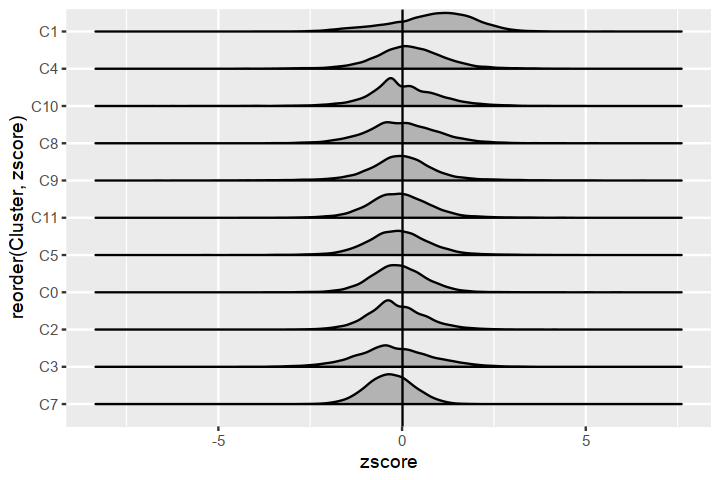

In [72]:
fig.size(4, 6)
fib$query$effects %>% 
    ggplot(aes(zscore, reorder(Cluster, zscore))) + 
        geom_density_ridges2(scale = .8) + 
#     ggplot(aes(zscore, color = Cluster)) + 
#         geom_density() + 
        geom_vline(xintercept = 0) + 
        NULL



In [71]:
table(fib$query$meta_data$Cluster)



  C0   C1  C10  C11  C12  C13   C2   C3   C4   C5   C6   C7   C8   C9 
 130 3414   92  158    2    3   78   72  283 1063   16 1211  166  864 

# Correlation 

In [7]:
prop_lineage <- obj$meta_data %>% 
    with(prop.table(table(lineage, LibraryID), 2)) %>% 
    data.table() %>% 
    subset(lineage %in% c('tcell', 'vascular_EC', 'mural'))
#     subset(lineage %in% c('tcell', 'vascular_EC', 'mural', 'lymphatic_EC', 'mono'))

prop_lineage <- data.table(prop_lineage)[, N_norm := qbeta(rank(N) / .N, .4, .4), by = lineage][]


In [8]:
prop_fibro <- fib$query$meta_data %>% 
    with(prop.table(table(Cluster, LibraryID), 2)) %>% 
    data.table() 


Joining, by = "LibraryID"

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



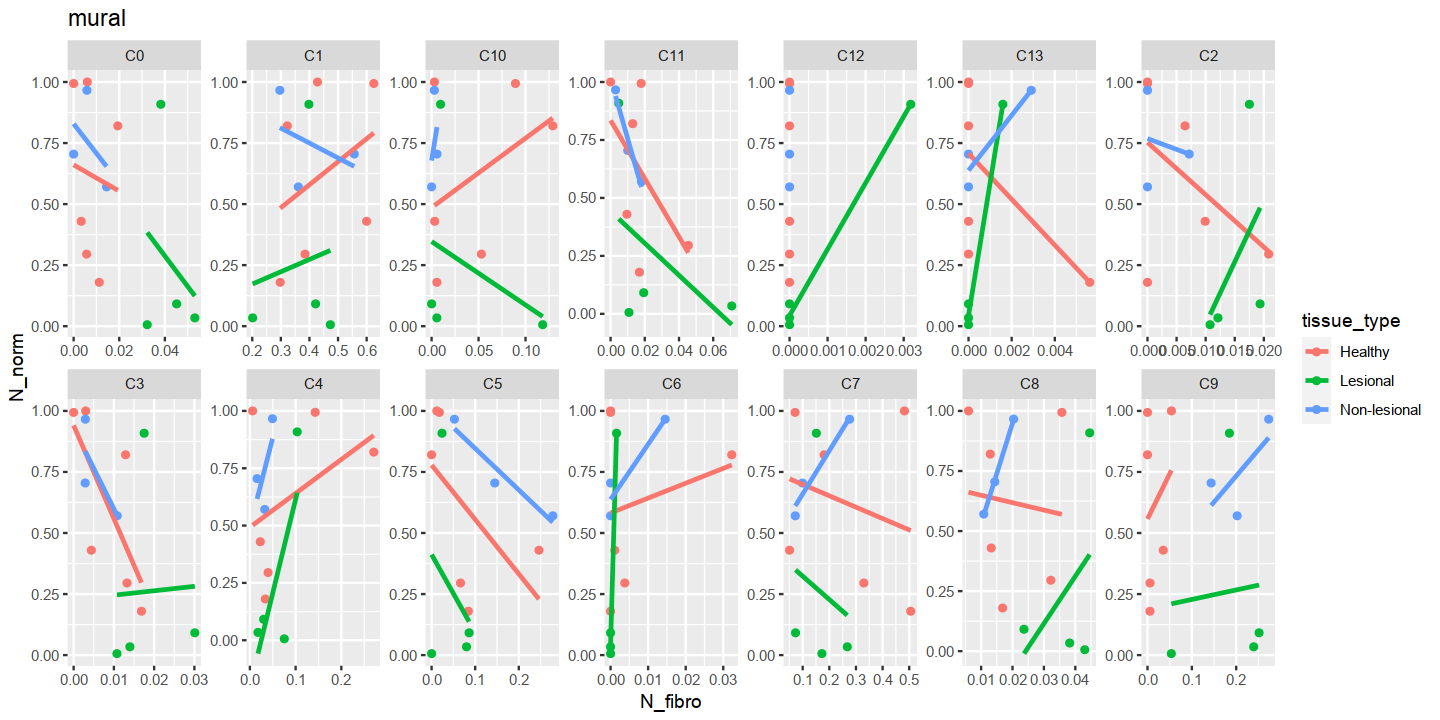

`geom_smooth()` using formula 'y ~ x'



$mural

$tcell

$vascular_EC


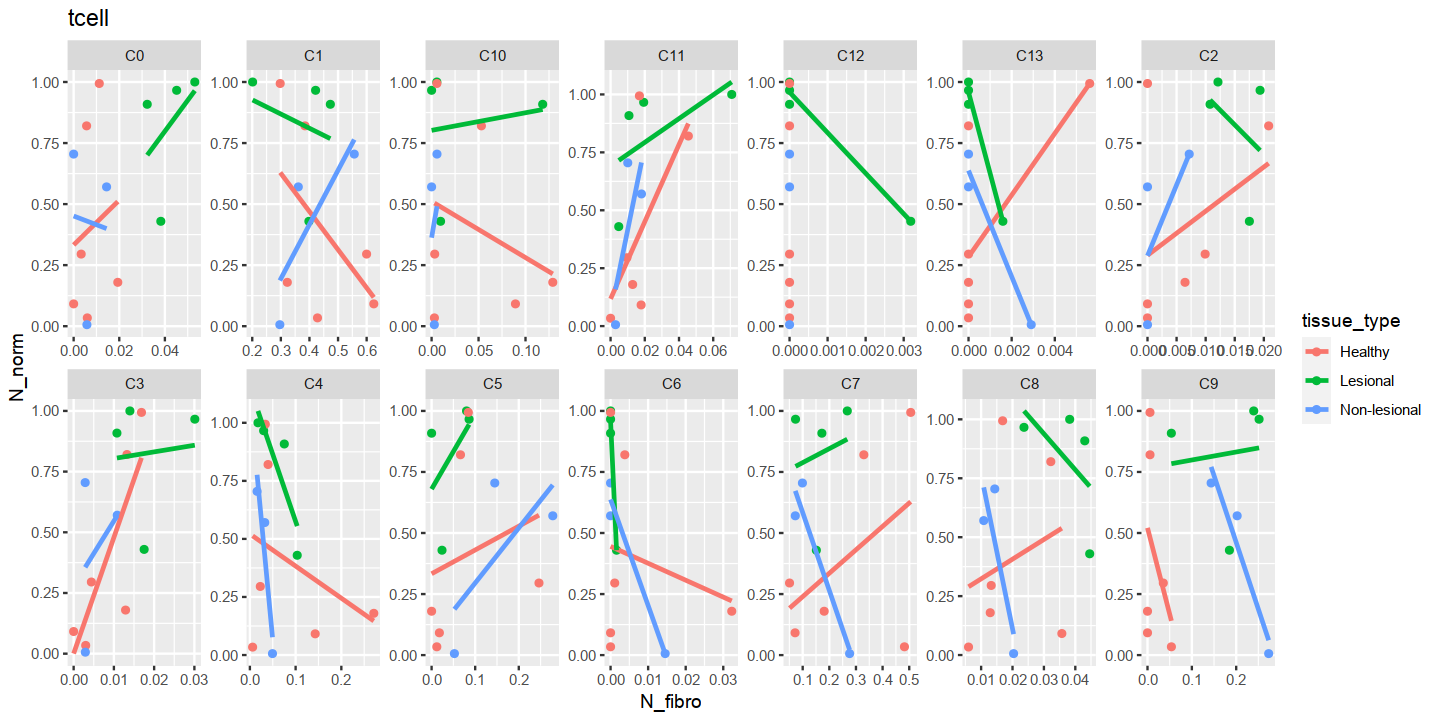

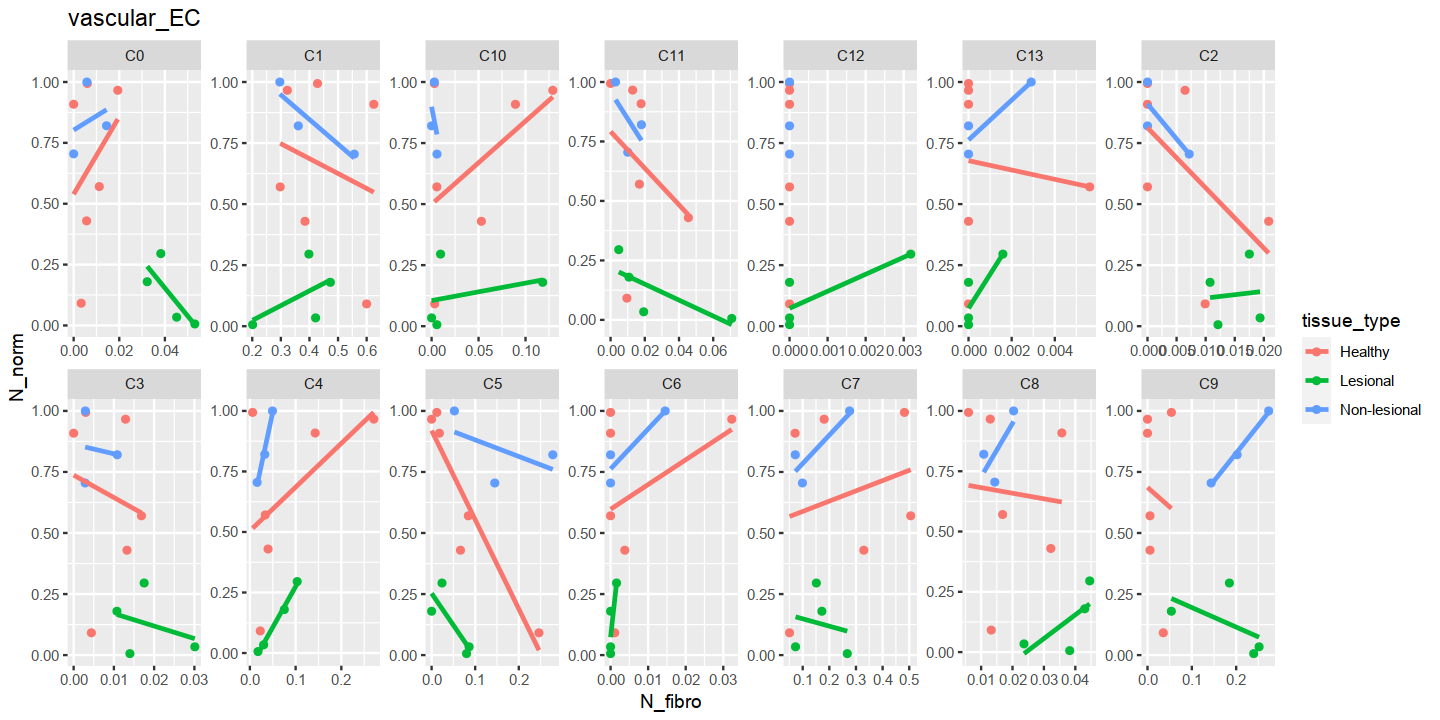

In [9]:
fig.size(6, 12)
inner_join(prop_lineage, prop_fibro, by = c('LibraryID'), suffix = c('_lineage', '_fibro')) %>% 
    left_join(unique(dplyr::select(obj$meta_data, LibraryID, tissue_type))) %>% 
    split(.$lineage) %>% 
    imap(function(.SD, .lineage) {
#         ggplot(.SD, aes(N_fibro, N_lineage)) + 
        ggplot(.SD, aes(N_fibro, N_norm, color = tissue_type)) + 
            geom_point() + 
            geom_smooth(method = 'lm', se = FALSE) + 
    #         facet_grid(Cluster ~ lineage) +
            facet_wrap( ~ Cluster, scales = 'free', nrow = 2) + 
            labs(title = .lineage) + 
            NULL
        
    })


## MASC

In [10]:
prop_lineage <- obj$meta_data %>% 
    with(prop.table(table(lineage, LibraryID), 2)) %>% 
    data.table() %>% 
    subset(lineage %in% c('tcell', 'vascular_EC', 'mural')) 


prop_lineage <- data.table(prop_lineage)[, N_norm := qbeta(rank(N) / .N, .4, .4), by = lineage][]


In [39]:
nsim <- 1e3
foo <- function(cluster_test, data_df, .formula, .contrast) {
    message(cluster_test)
    data_use <- data_df %>% 
        dplyr::mutate(Response = case_when(
            Cluster == cluster_test ~ 1L,
            TRUE ~ 0L
        ))
    
    tryCatch({
        model <- glmer(
#             formula = Response ~ 1 + InflamScore_beta + (scDblFinder.score+percent_mito||LibraryID), 
            formula = .formula, 
            data = data_use, 
            family = 'binomial'
        )
        tibble(
            Cluster = cluster_test,
            Ncells = sum(data_use$Response == 1L),
            beta = fixef(model)[[.contrast]] / log(2),
            sigma = sqrt(vcov(model)[.contrast, .contrast]) / log(2)
        ) %>% 
        dplyr::mutate(zscore = beta / sigma) %>% 
        dplyr::mutate(pvalue = pnorm(-zscore)) %>% 
#         dplyr::mutate(pvalue = 2 * pnorm(-abs(zscore))) %>% 
        return()

    }, error = function(e) {
        print(e)
        tibble(
            Cluster = cluster_test,
            Ncells = sum(data_use$Response == 1L),
            beta = NA,
            sigma = NA
        ) %>% 
        return()

    })    
}

In [40]:
library(lme4)
data_df <- fib$query$meta_data %>% 
    dplyr::select(-lineage) %>% 
    left_join(prop_lineage, by = 'LibraryID') %>% 
    dplyr::mutate(percent_mito = unlist(scale(percent_mito))) %>% 
    dplyr::select(-N) %>% ## spread doesn't work with both N and N_norm
    tidyr::spread(lineage, N_norm)
#     tidyr::spread(lineage, N)
clusters <- unique(data_df$Cluster)


In [15]:
# # clusters_use <- c('C11')
# clusters_use <- clusters

# res_lympho <- map(
#     clusters_use, foo, data_df, 
#     Response ~ 1 + tcell + tissue_type + (scDblFinder.score+percent_mito||LibraryID),
# #     Response ~ 1 + tcell + (scDblFinder.score+percent_mito||LibraryID),
#     'tcell'
# )
# names(res_lympho) <- clusters_use
# res_lympho <- bind_rows(res_lympho, .id = 'Cluster')


In [16]:
# res_lympho %>% arrange(-zscore)

In [17]:
# exp(4.06704)

In [46]:
clusters_use <- setdiff(clusters, c('C6', 'C12', 'C13'))
# clusters_use <- c('C4')
res_ec <- map(
    clusters_use, foo, data_df, 
    Response ~ 1 + vascular_EC + tissue_type + (scDblFinder.score+percent_mito||LibraryID),
#     Response ~ 1 + vascular_EC + (1|tissue_type) + (scDblFinder.score+percent_mito||LibraryID),
#     Response ~ 1 + vascular_EC + (scDblFinder.score+percent_mito||LibraryID),
    'vascular_EC'    
)
names(res_ec) <- clusters_use
res_ec <- bind_rows(res_ec, .id = 'Cluster')


C1

C9

C7

C5

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.074521 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”
C8

boundary (singular) fit: see ?isSingular

C11

C4

C0

boundary (singular) fit: see ?isSingular

C2

C3

C10



In [47]:
res_ec %>% 
    arrange(-zscore)


Cluster Ncells beta       sigma       zscore        pvalue    
1  C4       283    2.4851054 1.427373865     1.7410333 0.04083887
2  C7      1211    2.3858477 1.441065425     1.6556137 0.04890003
3  C0       130    1.6006334 1.018602379     1.5714016 0.05804470
4  C10       92    3.4643242 2.411445178     1.4366174 0.07541336
5  C3        72    0.7967200 1.355479968     0.5877771 0.27834097
6  C8       166    0.1747800 0.601570768     0.2905393 0.38570183
7  C9       864   -0.3681230 1.502048381    -0.2450807 0.59680301
8  C1      3414   -0.7360006 1.197317927    -0.6147077 0.73062612
9  C2        78   -2.5832592 1.788792177    -1.4441360 0.92564964
10 C11      158   -3.6929164 2.176955229    -1.6963676 0.95509186
11 C5      1063   -7.1658245 0.001369124 -5233.8765718 1.00000000

In [34]:
exp(2.485105)

[1] 12.00238

In [48]:
clusters_use <- setdiff(clusters, c('C6', 'C12', 'C13'))
# clusters_use <- c('C4')
res_mural <- map(
    clusters_use, foo, data_df, 
    Response ~ 1 + mural + tissue_type + (scDblFinder.score+percent_mito||LibraryID),
#     Response ~ 1 + mural + (1|tissue_type) + (scDblFinder.score+percent_mito||LibraryID),
#     Response ~ 1 + vascular_EC + (scDblFinder.score+percent_mito||LibraryID),
    'mural'    
)
names(res_mural) <- clusters_use
res_mural <- bind_rows(res_mural, .id = 'Cluster')


C1

C9

C7

C5

C8

boundary (singular) fit: see ?isSingular

C11

C4

C0

boundary (singular) fit: see ?isSingular

C2

C3

C10



In [49]:
res_mural %>% 
    arrange(-zscore)


Cluster Ncells beta        sigma     zscore     pvalue      
1  C4       283    3.23982754 0.7569203  4.2802756 9.333101e-06
2  C0       130    0.37591972 0.6128929  0.6133531 2.698215e-01
3  C1      3414    0.53982596 0.9234487  0.5845760 2.794164e-01
4  C10       92    1.20286982 2.1152316  0.5686705 2.847899e-01
5  C9       864    0.37568738 1.1218013  0.3348965 3.688516e-01
6  C8       166   -0.04849982 0.4454057 -0.1088891 5.433548e-01
7  C7      1211   -0.18345886 1.2318443 -0.1489302 5.591957e-01
8  C3        72   -1.07744935 1.1258603 -0.9570009 8.307166e-01
9  C2        78   -1.13742278 1.0090137 -1.1272620 8.701841e-01
10 C11      158   -5.58198315 1.6179956 -3.4499372 9.997196e-01
11 C5      1063   -4.73483714 1.3417707 -3.5287977 9.997913e-01

This is the same normalized inflammation score MASC but this time, letting histology be its own effect. 

In [50]:
clusters_use <- setdiff(clusters, c('C6', 'C12', 'C13'))
# clusters_use <- c('C4')
res_inflam2 <- map(
    clusters_use, foo, data_df, 
    Response ~ 1 + InflamScore_beta + tissue_type + (scDblFinder.score+percent_mito||LibraryID),
#     Response ~ 1 + InflamScore_beta + (1|tissue_type) + (scDblFinder.score+percent_mito||LibraryID),
    'InflamScore_beta'    
)
names(res_inflam2) <- clusters_use
res_inflam2 <- bind_rows(res_inflam2, .id = 'Cluster')


C1

C9

C7

C5

C8

boundary (singular) fit: see ?isSingular

C11

C4

C0

boundary (singular) fit: see ?isSingular

C2

C3

C10



In [51]:
res_inflam2 %>% 
    arrange(-zscore)


Cluster Ncells beta       sigma     zscore     pvalue     
1  C11      158    4.0670400 1.3174737  3.0869990 0.001010941
2  C5      1063    3.7089835 1.5856996  2.3390203 0.009667191
3  C3        72    2.0441468 1.0968954  1.8635750 0.031190708
4  C2        78    1.3724875 1.0141851  1.3532909 0.087981355
5  C8       166    0.3836796 0.5165003  0.7428449 0.228787793
6  C7      1211    0.5904717 1.2185484  0.4845698 0.313990784
7  C10       92   -0.6815953 2.1756163 -0.3132884 0.622969213
8  C1      3414   -0.4504338 0.9253469 -0.4867729 0.686790363
9  C0       130   -0.5139847 0.8356497 -0.6150719 0.730746393
10 C9       864   -1.6605649 1.0491464 -1.5827771 0.943263858
11 C4       283   -2.7374450 1.1490798 -2.3822932 0.991397403

In [52]:
fib$query$masc_mural <- res_mural
fib$query$masc_inflam2 <- res_inflam2
fib$query$masc_ec <- res_ec


# Comparison to COL6A5+COL18A1+

Comment: 

    8) The authors validated their integrated analysis using an independent previously published scRNAseq dataset from patients with atopic dermatitis. They were able to identify most of the clusters they have previously described and found that the inflammatory CXCL10+CCL19+ C11 cluster was expanded in patients with lesional AD. It would be interesting to also analyze what is the similarity between the novel COL6A5+COL18A1+ subpopulation that He et al., described in their original publication with the C11 cluster that the authors describe, since both of them express CCL19.



In [2]:
## fib <- readRDS('/data/srlab2/ik936/Roche/data/eczema/obj_fib.rds')

In [3]:
eff <- fib$query$effects

In [4]:
obj <- readRDS('/data/srlab2/ik936/Roche/data/eczema/obj_all.rds')

In [5]:
effects_he <- openxlsx::read.xlsx('/data/srlab2/ik936/Roche/data/eczema/mmc9.xlsx', 'Fibroblasts')

In [6]:
# eff <- readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_marginal.rds')

In [7]:
table(fib$query$meta_data$Cluster)


  C0   C1  C10  C11  C12  C13   C2   C3   C4   C5   C6   C7   C8   C9 
 130 3414   92  158    2    3   78   72  283 1063   16 1211  166  864 

In [8]:
eff %>%
#     subset(feature == 'MKI67') %>% 
    subset(Cluster == '0') %>% 
    arrange(-beta) %>% 
    head(20)


contrast feature beta sigma zscore pvalue Cluster

## COL6A5+COL18A1+ fibroblasts consistent with C0 and C11 

In [9]:
# fib$query$effects %>% 
#     subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene) %>% 
#     split(.$Cluster) %>% 
#     map(arrange, -beta) %>% 
#     map(head)

In [10]:
# fib$query$effects %>% 
#     subset(feature == 'POSTN')

In [11]:
# effects_he %>% subset(gene == 'POSTN')

In [12]:
fib$query$effects %>% 
#     subset(feature %in% c('COL6A1', 'COL6A2')) %>% 
    subset(feature %in% c('COL6A5', 'COL18A1')) %>% 
    subset(beta > 0 & pvalue < .05) %>% 
    split(.$feature)
#     arrange(-beta)


$COL18A1
# A tibble: 3 x 7
  contrast feature  beta sigma zscore  pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>   <dbl> <chr>  
1 C11      COL18A1 0.939 0.311   3.02 0.00255 C11    
2 C4       COL18A1 0.704 0.286   2.46 0.0140  C4     
3 C0       COL18A1 0.638 0.290   2.20 0.0278  C0     

$COL6A5
# A tibble: 4 x 7
  contrast feature  beta sigma zscore   pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>  
1 C11      COL6A5  1.36  0.378   3.61 0.000309 C11    
2 C0       COL6A5  1.14  0.332   3.43 0.000600 C0     
3 C1       COL6A5  1.02  0.306   3.31 0.000922 C1     
4 C8       COL6A5  0.875 0.408   2.15 0.0319   C8

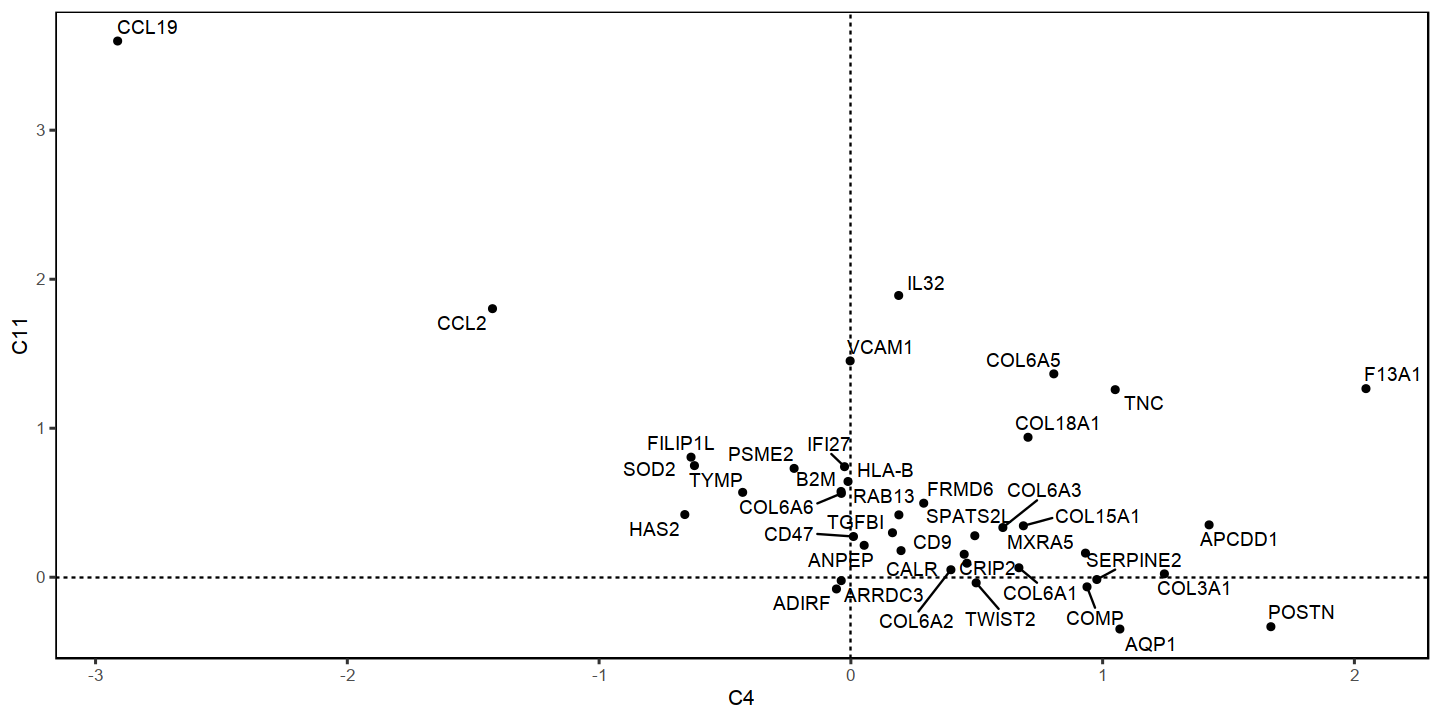

In [13]:
fig.size(6, 12)
fib$query$effects %>% 
    subset(Cluster %in% c('C4', 'C11')) %>% 
#     subset(pvalue < .05) %>% 
    subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene) %>% 
    dplyr::select(feature, Cluster, beta) %>% 
    tidyr::spread(Cluster, beta) %>% 
    ggplot(aes(C4, C11)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_point() + 
        geom_text_repel(aes(label = feature), max.overlaps = Inf) + 
#         geom_point(
#             data = . %>% subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene),
#             color = 'red'
#         ) + 
        NULL

In [14]:
# fib$query$effects %>% 
#     subset(feature == 'CCL19') %>% 
#     arrange(-beta)

In [15]:
# effects_he %>% split(.$cluster) %>% map(arrange, -avg_logFC) %>% 
#     map(head)
effects_he %>% subset(gene == 'COL3A1')

p_val    avg_logFC pct.1 pct.2 p_val_adj cluster         gene  
92  2.76e-33 0.7918588 0.832 0.618 5.04e-29  COL11A1+LAMC3+  COL3A1
130 7.02e-56 0.8629637 0.851 0.612 1.28e-51  COL6A5+COL18A1+ COL3A1

In [16]:
fib$query$effects %>% 
    subset(feature %in% c('COL6A5', 'COL18A1', 'CCL19', 'VCAM1', 'CCL2', 'TNC')) %>% 
    subset(pvalue < .05 & beta > 0) %>% 
    split(.$feature) %>% 
    map(arrange, -beta)

$CCL19
# A tibble: 4 x 7
  contrast feature  beta sigma zscore    pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>     <dbl> <chr>  
1 C11      CCL19    3.60 0.841   4.28 0.0000187 C11    
2 C0       CCL19    2.53 0.833   3.04 0.00238   C0     
3 C3       CCL19    2.09 0.628   3.33 0.000882  C3     
4 C8       CCL19    1.69 0.775   2.18 0.0291    C8     

$CCL2
# A tibble: 3 x 7
  contrast feature  beta sigma zscore   pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>  
1 C11      CCL2    1.80  0.625   2.88 0.00392  C11    
2 C8       CCL2    1.50  0.413   3.64 0.000277 C8     
3 C3       CCL2    0.774 0.360   2.15 0.0315   C3     

$COL18A1
# A tibble: 3 x 7
  contrast feature  beta sigma zscore  pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>   <dbl> <chr>  
1 C11      COL18A1 0.939 0.311   3.02 0.00255 C11    
2 C4       COL18A1 0.704 0.286   2.46 0.0140  C4     
3 C0       COL18A1 0.638 0.290   2.20 0.0278  C0     

$COL6A5
# A tibble: 4 x 7
  contrast feature  beta sigma zscore   pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>    <dbl> <chr>  
1 C11      COL6A5  1.36  0.378   3.61 0.000309 C11    
2 C0       COL6A5  1.14  0.332   3.43 0.000600 C0     
3 C1       COL6A5  1.02  0.306   3.31 0.000922 C1     
4 C8       COL6A5  0.875 0.408   2.15 0.0319   C8     

$TNC
# A tibble: 4 x 7
  contrast feature  beta sigma zscore        pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>         <dbl> <chr>  
1 C0       TNC     2.38  0.408   5.84 0.00000000520 C0     
2 C11      TNC     1.26  0.420   3.00 0.00272       C11    
3 C4       TNC     1.05  0.462   2.27 0.0229        C4     
4 C8       TNC     0.885 0.451   1.96 0.0495        C8     

$VCAM1
# A tibble: 1 x 7
  contrast feature  beta sigma zscore    pvalue Cluster
  <chr>    <chr>   <dbl> <dbl>  <dbl>     <dbl> <chr>  
1 C11      VCAM1    1.45 0.373   3.89 0.0000994 C11

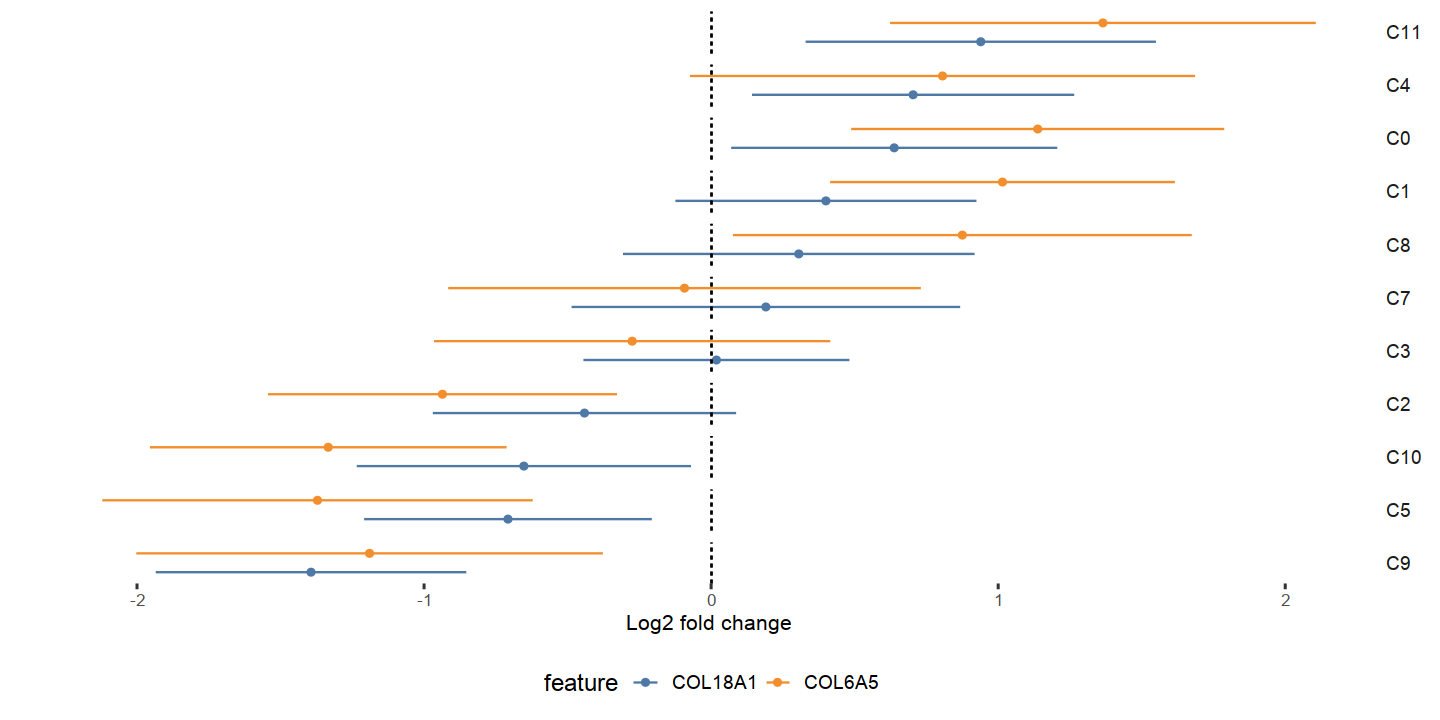

In [17]:
cluster_levels <- fib$query$effects %>% 
    subset(feature %in% c('COL18A1')) %>% 
    arrange(-beta) %>% with(Cluster)
    

fib$query$effects %>% 
#     dplyr::mutate(sigma = pmin(sigma, sigma_max)) %>% 
    subset(feature %in% c('COL6A5', 'COL18A1')) %>% 
    dplyr::mutate(Cluster = factor(Cluster, cluster_levels)) %>% 
    ggplot(aes(feature, beta, color = feature)) +
        geom_point() + 
        geom_errorbar(aes(ymin = beta - 1.96 * sigma, ymax = beta + 1.96 * sigma), width = 0) + 
        coord_flip() + 
        facet_grid(Cluster ~ ., space = "free", scales = "free", switch = NULL) + 
        geom_hline(yintercept = c(0), linetype = 2) + 
        labs(x = "", y = "Log2 fold change") + 
        geom_hline(yintercept = c(0), linetype = 2) + 
        theme(
            axis.text.y = element_blank(), 
            axis.ticks.y = element_blank(), legend.position = "bottom", 
            strip.text.y = element_text(angle = 0, hjust = 0), panel.background = element_blank()
        ) + 
        scale_color_tableau() + 
        NULL

In [18]:
# fig.size(5, 6)
#  %>% subset(feature %in% c('COL6A5', 'COL18A1')) %>% dplyr::mutate(fdr = 0) %>% forest_uni(fdr_max = Inf)a



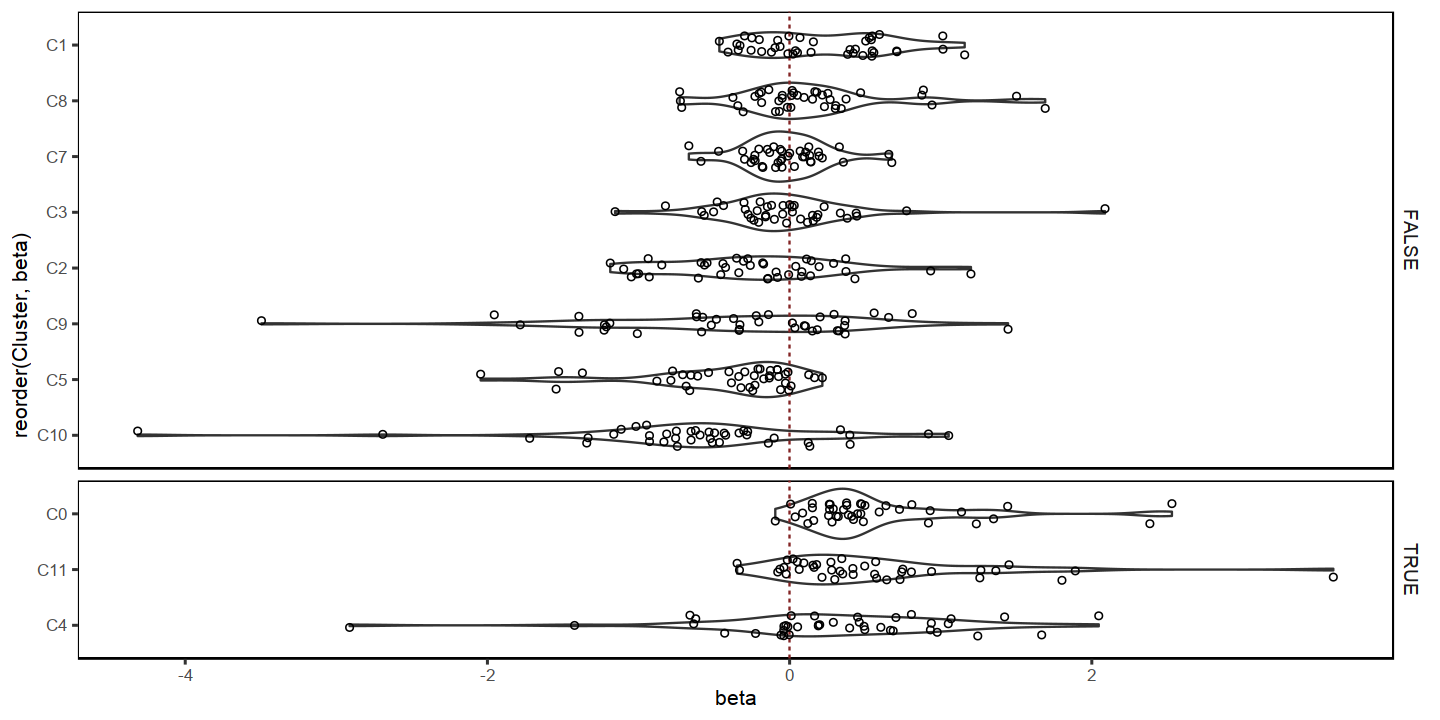

In [19]:
fib$query$effects %>% 
    subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene) %>% 
    ggplot(aes(reorder(Cluster, beta), beta)) + 
#         geom_boxplot(outlier.shape = NA) + 
        geom_violin() + 
        geom_hline(yintercept = 0, linetype = 2, color = muted('red')) + 
        geom_point(position = position_jitter(width = .2, height = 0), shape = 21) + 
        coord_flip() + 
        facet_grid(Cluster %in% c('C0', 'C11', 'C4')~., scales = 'free', space = 'free') + 
        NULL


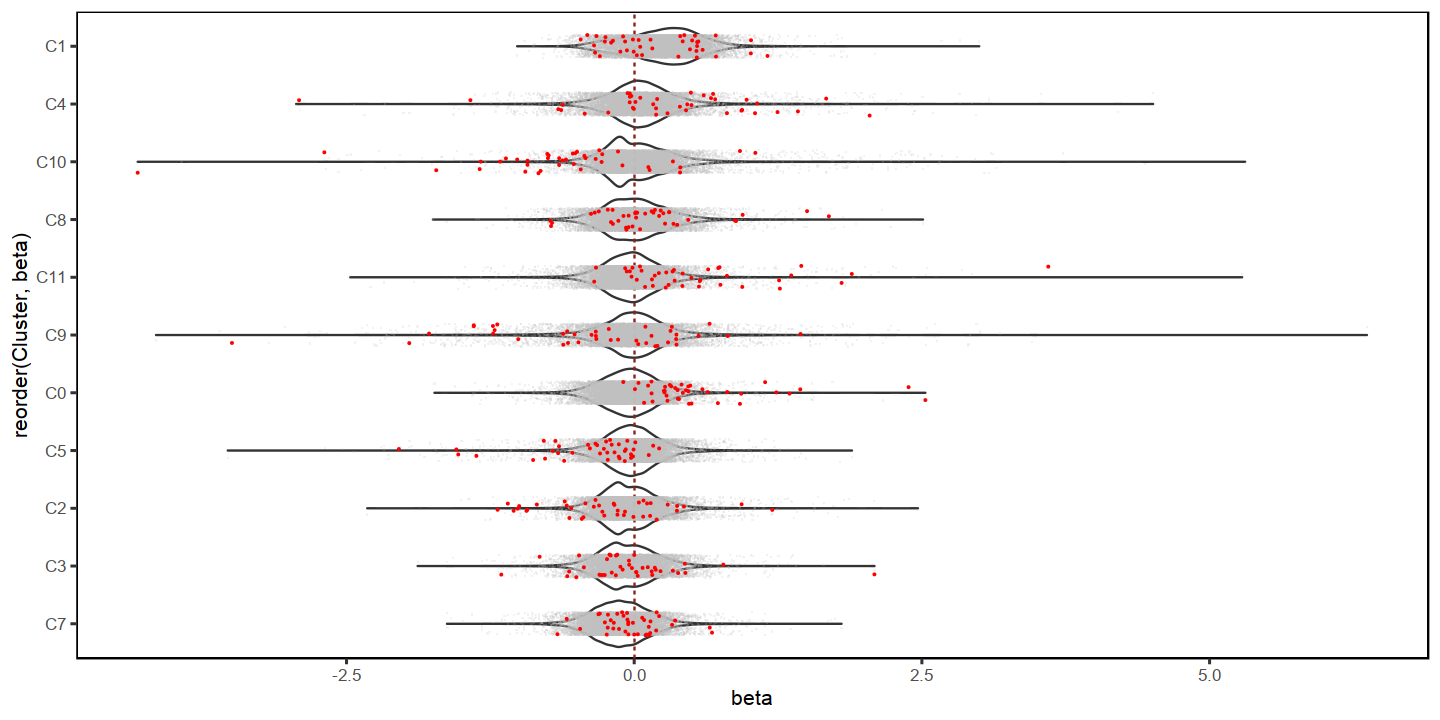

In [20]:
fib$query$effects %>% 
    ggplot(aes(reorder(Cluster, beta), beta)) + 
#         geom_boxplot(outlier.shape = NA) + 
        geom_violin() + 
        geom_hline(yintercept = 0, linetype = 2, color = muted('red')) + 
#         geom_point(position = position_jitter(width = .2, height = 0), shape = 21) + 
        geom_point(
            data = . %>% subset(!feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene),
            color = 'grey', 
            alpha = .2,
            position = position_jitter(width = .2, height = 0), shape = '.'
        ) + 
        geom_point(
            data = . %>% subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene),
            color = 'red', 
            position = position_jitter(width = .2, height = 0), shape = 16, size = .5 
        ) + 
        coord_flip() + 
        NULL


In [21]:
## Let's get some stats on this 
.x <- fib$query$effects %>% 
#     subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene) %>% 
    subset(pvalue < 1e-6 & beta > 0) 
all_genes <- unique(fib$query$effects$feature)

In [22]:
.x %>% split(.$Cluster) %>% map(function(.SD) {
    suppressWarnings({
        table(
            all_genes %in% .SD$feature,
            all_genes %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene
        ) %>%
            chisq.test() %>% 
            broom::tidy() %>% 
            dplyr::mutate(OR = log(statistic))        
    })
}) %>% bind_rows(.id = 'Cluster') %>% 
    arrange(p.value)


Cluster statistic    p.value      parameter
1 C0      3.825657e+02 3.438486e-85 1        
2 C4      1.072131e+02 3.997786e-25 1        
3 C11     4.184380e+01 9.886373e-11 1        
4 C9      1.855802e+00 1.731101e-01 1        
5 C8      1.943866e-23 1.000000e+00 1        
6 C3      4.857543e-24 1.000000e+00 1        
7 C10     2.129622e-28 1.000000e+00 1        
8 C2      2.129622e-28 1.000000e+00 1        
9 C1      5.026945e-29 1.000000e+00 1        
  method                                                       OR         
1 Pearson's Chi-squared test with Yates' continuity correction   5.9469005
2 Pearson's Chi-squared test with Yates' continuity correction   4.6748188
3 Pearson's Chi-squared test with Yates' continuity correction   3.7339437
4 Pearson's Chi-squared test with Yates' continuity correction   0.6183167
5 Pearson's Chi-squared test with Yates' continuity correction -52.2947782
6 Pearson's Chi-squared test with Yates' continuity correction -53.6815094
7 Pearson's Chi-squared test with Yates' continuity correction -63.7164382
8 Pearson's Chi-squared test with Yates' continuity correction -63.7164382
9 Pearson's Chi-squared test with Yates' continuity correction -65.1601553

In [23]:
# fig.size(8, 12)
# effects_he %>% 
#     left_join(fib$query$effects, by = c('gene' = 'feature')) %>% 
#     subset(!is.na(cluster) & !is.na(Cluster)) %>% 
#     ggplot(aes(avg_logFC, beta)) + 
#         geom_point(shape = 16, size = .5) + 
#         facet_grid(cluster ~ Cluster) + 
#         geom_hline(yintercept = 0, linetype = 2) + 
#         geom_vline(xintercept = 0, linetype = 2) + 
#         NULL


## Vs C11

In [24]:
fib$query$effects %>% 
    subset(feature %in% subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene) %>% 
    subset(Cluster == 'C11') %>% 
    arrange(beta)

contrast feature  beta        sigma     zscore      pvalue       Cluster
1  C11      AQP1     -0.34752090 0.4307113 -0.80685350 4.197509e-01 C11    
2  C11      POSTN    -0.33185703 0.3264284 -1.01663052 3.093292e-01 C11    
3  C11      ADIRF    -0.07855318 0.2113104 -0.37174307 7.100842e-01 C11    
4  C11      COMP     -0.06442569 0.4411286 -0.14604744 8.838839e-01 C11    
5  C11      TWIST2   -0.03769466 0.2103953 -0.17916112 8.578112e-01 C11    
6  C11      ARRDC3   -0.02279415 0.2189419 -0.10411050 9.170817e-01 C11    
7  C11      SERPINE2 -0.01524355 0.2653975 -0.05743668 9.541973e-01 C11    
8  C11      COL3A1    0.02281115 0.2400019  0.09504571 9.242785e-01 C11    
9  C11      COL6A2    0.05037198 0.2102412  0.23959138 8.106470e-01 C11    
10 C11      COL6A1    0.06359678 0.2116757  0.30044441 7.638382e-01 C11    
11 C11      CRIP2     0.09428669 0.2370196  0.39780128 6.907767e-01 C11    
12 C11      CD9       0.15423584 0.2125595  0.72561262 4.680763e-01 C11    
13 C11      MXRA5     0.16202374 0.1994336  0.81241932 4.165511e-01 C11    
14 C11      CALR      0.17869789 0.2103045  0.84971033 3.954862e-01 C11    
15 C11      ANPEP     0.21431849 0.2312918  0.92661505 3.541264e-01 C11    
16 C11      CD47      0.27339335 0.2105918  1.29821474 1.942136e-01 C11    
17 C11      SPATS2L   0.27860856 0.2214916  1.25787398 2.084373e-01 C11    
18 C11      TGFBI     0.29873748 0.1809068  1.65133330 9.867054e-02 C11    
19 C11      COL6A3    0.33359842 0.2066797  1.61408398 1.065092e-01 C11    
20 C11      COL15A1   0.34527392 0.2987343  1.15578926 2.477674e-01 C11    
21 C11      APCDD1    0.35145704 0.2672699  1.31498909 1.885136e-01 C11    
22 C11      RAB13     0.41864396 0.2311125  1.81142949 7.007439e-02 C11    
23 C11      HAS2      0.42067969 0.2372321  1.77328312 7.618181e-02 C11    
24 C11      FRMD6     0.49693588 0.2329136  2.13356330 3.287854e-02 C11    
25 C11      COL6A6    0.56265223 0.2086850  2.69617908 7.013995e-03 C11    
26 C11      TYMP      0.56959881 0.2058519  2.76703226 5.656916e-03 C11    
27 C11      B2M       0.57566432 0.2114969  2.72185754 6.491612e-03 C11    
28 C11      HLA-B     0.64269772 0.1888301  3.40357681 6.650971e-04 C11    
29 C11      PSME2     0.73046575 0.2135526  3.42054241 6.249639e-04 C11    
30 C11      IFI27     0.74195629 0.1965164  3.77554443 1.596586e-04 C11    
31 C11      SOD2      0.74907323 0.2113265  3.54462570 3.931710e-04 C11    
32 C11      FILIP1L   0.80594245 0.1876985  4.29381437 1.756293e-05 C11    
33 C11      COL18A1   0.93929344 0.3113527  3.01681475 2.554459e-03 C11    
34 C11      TNC       1.25887486 0.4199719  2.99752154 2.721846e-03 C11    
35 C11      F13A1     1.26578917 0.4251171  2.97750682 2.906032e-03 C11    
36 C11      COL6A5    1.36486294 0.3783099  3.60779038 3.088158e-04 C11    
37 C11      VCAM1     1.45184910 0.3730268  3.89207759 9.938945e-05 C11    
38 C11      CCL2      1.80236753 0.6248804  2.88433986 3.922352e-03 C11    
39 C11      IL32      1.89088129 0.2742018  6.89594815 5.350671e-12 C11    
40 C11      CCL19     3.59845868 0.8407070  4.28027674 1.866611e-05 C11

## GSEA

In [25]:
library(fgsea)

In [26]:
gs <- list(he = subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene)
suppressWarnings({
    gsea_res <- fib$query$effects %>% 
    #     inner_join(gs_turley, by = c('MGI.symbol' = 'Gene')) %>% 
        split(.$Cluster) %>% map(function(.SD) {
            x <- .SD$beta
            names(x) <- .SD$feature
            fgsea(gs, x)
        }) %>% 
            bind_rows(.id = 'Cluster')
}) 


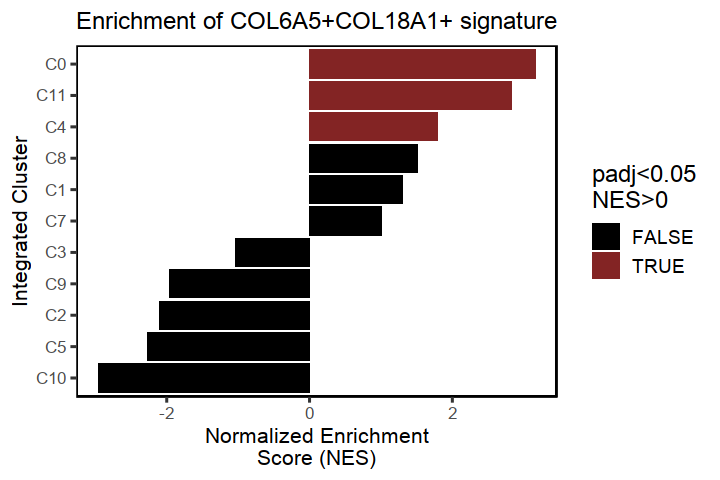

In [27]:
fig.size(4, 6)
p1 <- gsea_res %>% arrange(-NES) %>% 
#     ggplot(aes(reorder(Cluster, NES), sign(ES)*-log10(padj))) + 
    ggplot(aes(reorder(Cluster, NES), NES, fill = padj < .01 & NES > 0)) + 
        geom_bar(stat = 'identity') + 
        coord_flip() + 
        scale_fill_manual(values = c('black', muted('red'))) + 
        labs(
            y = 'Normalized Enrichment\nScore (NES)', x = 'Integrated Cluster',
            fill = 'padj<0.05\nNES>0', subtitle = 'Enrichment of COL6A5+COL18A1+ signature'
        ) + 
        NULL

#%>% subset(padj < .01 & NES > 0)
p1

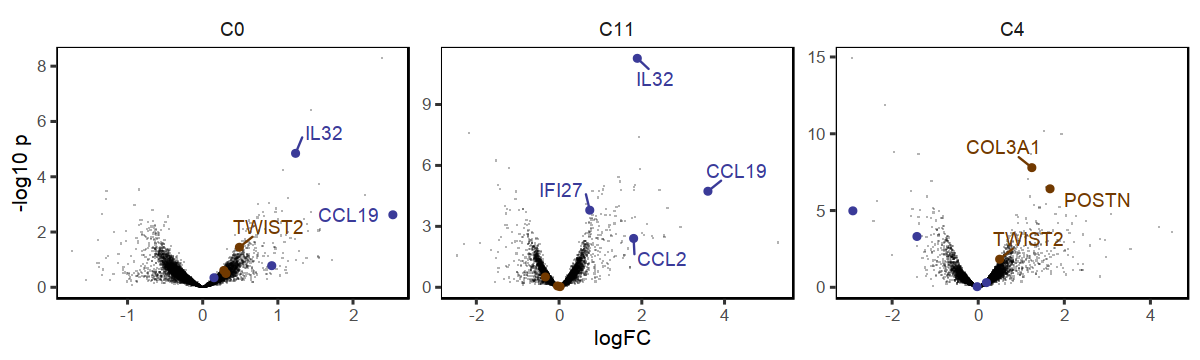

In [28]:
fig.size(3, 10)
set.seed(43)
p2 <- eff %>% 
    subset(Cluster %in% c('C0', 'C4', 'C11')) %>% 
#     ggplot(aes(beta, abs(zscore))) + 
    ggplot(aes(beta, -log10(pvalue))) + 
        geom_point(shape = '.', alpha = .3) + 
        geom_point(data = . %>% subset(feature %in% c('POSTN', 'COL3A1', 'TWIST2')), color = muted('orange')) +
        geom_point(data = . %>% subset(feature %in% c('IFI27', 'IL32', 'CCL19', 'CCL2', 'IL32')), color = muted('blue')) +
        geom_text_repel(
            seed = 50, 
            data = . %>% subset(feature %in% c('POSTN', 'COL3A1', 'TWIST2') & pvalue < .1 & beta > 0),
            color = muted('orange'),
            aes(label = feature),
            box.padding = .5
        ) + 
        geom_text_repel(
            seed = 44, 
            data = . %>% subset(feature %in% c('IFI27', 'IL32', 'CCL19', 'CCL2', 'IL32') & pvalue < .1 & beta > 0),
            color = muted('blue'),
            aes(label = feature),
            box.padding = .5
        ) + 
        facet_wrap(~Cluster, scales = 'free') + 
        labs(x = 'logFC', y = '-log10 p') + 
        NULL
p2

## Top markers for C0, C4, and C11 in gut 

In [35]:
g <- eff %>% 
    subset(Cluster %in% c('C0', 'C4', 'C11')) %>% 
    split(.$Cluster) %>% 
    map(function(.SD) {
        .SD %>% arrange(-zscore) %>% head(20) %>% with(feature)
    }) %>% 
    reduce(union) 
# %>% 
#     union(subset(effects_he, cluster == 'COL6A5+COL18A1+')$gene)

X <- eff %>% 
    subset(Cluster %in% c('C4', 'C0', 'C11')) %>% 
    subset(feature %in% g) %>% 
#     dplyr::select(feature, Cluster, beta) %>% 
#     tidyr::spread(Cluster, beta, fill = 0) %>% 
    dplyr::select(feature, Cluster, zscore) %>% 
    tidyr::spread(Cluster, zscore, fill = 0) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix()# %>% t()

# X <- X %>% pmin(5) %>% pmax(-5)
dim(X)

[1] 58  3

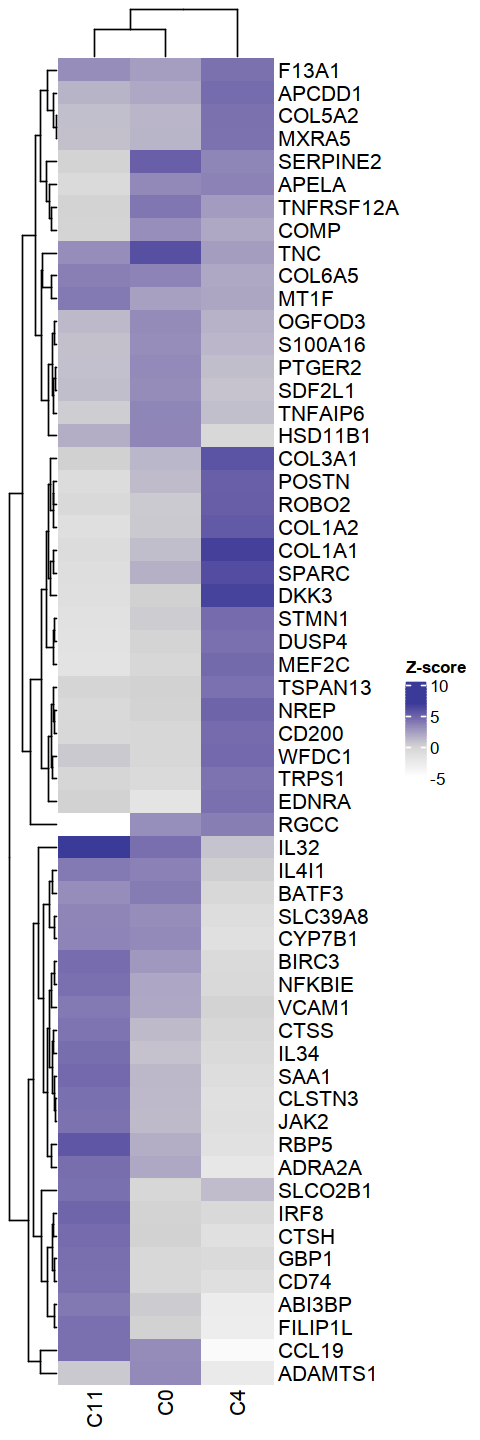

In [36]:
fig.size(12, 4)
Heatmap(
    X,
    name = 'Z-score',
    colorRamp2(c(min(X), 0, max(X)), c('white', 'lightgrey', muted('blue'))),      
#     colorRamp2(c(-max(X), 0, max(X)), c('white', 'white', muted('blue'))),      
)


In [37]:
sort(table(fib$query$meta_data$Cluster))


 C12  C13   C6   C3   C2  C10   C0  C11   C8   C4   C9   C5   C7   C1 
   2    3   16   72   78   92  130  158  166  283  864 1063 1211 3414 

In [38]:
# fig.size(6, 10)
# do_scatter(fib$query$U, fib$query$meta_data, 'Cluster', quo(Cluster), nrow = 3, pt_shape = 16, do_labels = FALSE)

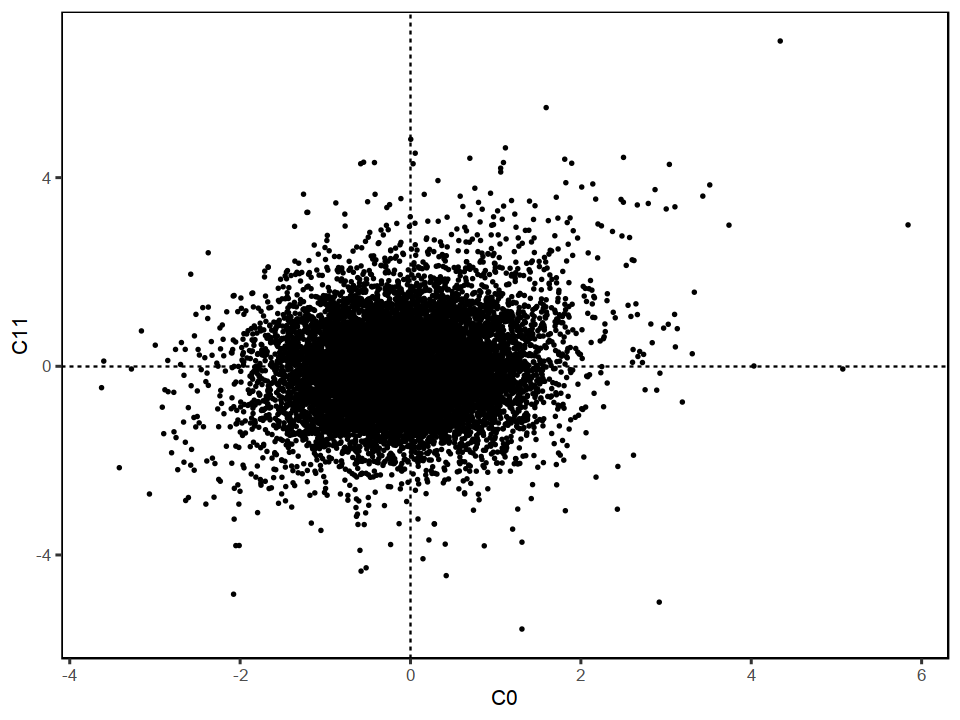

In [39]:
fig.size(6, 8)
.x <- eff %>% 
    dplyr::select(feature, Cluster, zscore) %>% 
    tidyr::spread(Cluster, zscore, fill = 0) 

ggplot(.x, aes(C0, C11)) +
    geom_hline(yintercept = 0, linetype = 2) + 
    geom_vline(xintercept = 0, linetype = 2) + 
    geom_point(size = .5) + 
    NULL



In [40]:
.x %>% subset(C0 > 2 & C11 > 2)

feature    C0       C1          C10         C11      C2          C3         
1  ADAMTS8    2.371156 -0.20251440 -0.68943134 2.858661  0.45397942 -0.03789394
2  BATF3      3.738692 -1.09071055 -1.92622763 2.992428 -1.83871141 -0.09011515
3  BIRC3      2.500430 -0.05542229 -2.35228569 4.428709 -0.49668761  0.34822416
4  CCL19      3.038701  0.63614521 -5.13374965 4.280277  1.43589597  3.32574550
5  CD82       2.870674  0.10812456  0.22024801 3.745474 -0.35002405  0.35142662
6  COL18A1    2.200518  1.49420961 -2.19617770 3.016815 -1.63646983  0.07795399
7  COL6A5     3.431456  3.31343048 -4.20805307 3.607790 -3.01722307 -0.78111681
8  CSGALNACT1 2.085782  0.43953978 -0.88771448 2.403502  0.18246863 -0.31296161
9  CYP7B1     3.104107  1.10140697 -2.90361506 3.380562 -0.62310944  2.46070585
10 DDIT4      2.482265 -3.91471762  0.06575505 2.763111  1.90197675 -1.84448301
11 EGLN3      2.791192 -0.76075979 -1.68726525 3.452055  0.45943763  1.40380145
12 F13A1      2.241551  1.95400726 -2.76126891 2.977507 -3.13225827 -1.42509240
13 IL15       2.009893  0.96752893 -1.55988008 3.800389 -0.99544785 -0.58876468
14 IL32       4.340261 -1.29139247 -6.16578947 6.895948 -1.14053244 -0.79436752
15 IL4I1      3.512947  0.85320555 -1.78449834 3.845004  0.15795994  0.35217275
16 LAP3       2.498945 -1.10042277 -3.08616872 3.478302 -1.03072558  2.64983523
17 MEOX1      2.471651  0.22123184 -1.10298559 3.537858 -1.20796612 -0.50524706
18 MT1F       2.139926 -0.76445808  1.28103377 3.865571 -1.99303175 -1.45069965
19 NINJ1      2.602332 -1.10576844 -0.19201442 2.256954  0.12344328 -0.25683893
20 PDPN       2.571804 -2.33176332 -1.82698028 2.730202 -0.66244739  1.72923477
21 PHLDA2     2.532434 -1.93656743 -0.38534702 2.139231  0.61486075 -0.54634524
22 PSME2      2.662532 -2.27189317 -1.24813764 3.420542 -0.02913932  0.81567379
23 SLC39A8    3.001771 -0.98133208  0.20349635 3.335324 -1.11760207  0.10769784
24 SOD2       2.173795 -1.02664303 -0.46896794 3.544626  2.03131412  1.25513824
25 TNC        5.840649  1.43084407 -1.58746157 2.997522 -2.68882169 -2.29315600
26 TNFAIP8    2.196815 -0.07510866  0.03954164 2.298567 -0.07759510  0.49910535
27 TNIP1      2.623726 -0.30332795 -0.13761213 2.242504  0.69516428  0.04080398
   C4          C5           C7         C8         C9        
1   1.26992097 -2.096725775 -0.6687840 -1.9371157 -1.1487531
2  -0.54852200 -3.297006524 -0.6444093  2.4673776 -0.5708224
3  -0.83935421 -2.025900142 -1.5249784  1.3152899 -1.8826436
4  -4.40728836 -2.518848999  0.9576830  2.1819909 -4.6926066
5  -1.10914782 -2.067256491 -1.0852887 -1.3679028 -1.9265218
6   2.45719069 -2.767968653  0.5523455  0.9772307 -5.0499186
7   1.79573704 -3.584407687 -0.2208880  2.1461042 -2.8697688
8  -1.21944392  0.489171902 -1.1939178  0.1429517 -1.7336140
9  -1.53655999  0.003310564 -1.6787321 -0.5386833 -3.3992473
10  0.44895302 -1.448857282 -0.7268964  1.5337283 -0.6390611
11 -1.46700249 -2.182306374 -0.8987677 -0.1532955 -1.6802812
12  4.25625606 -4.333743989  0.7363025  0.5085286 -3.3916649
13  0.07035306 -0.916967427 -0.8189542  0.7588100 -2.2962570
14  0.68429399 -2.275283837 -0.4387861  0.8185600 -0.7270290
15  0.20985130 -4.318463377  0.4447530 -0.6172799 -3.0895575
16 -0.84273865 -1.832218823 -0.5933967  1.5560977 -1.3477205
17 -0.11046739 -1.637508684 -0.5076072  0.0920940 -1.1588538
18  1.89656176 -2.169052088  0.6905431  1.5219618 -6.1553764
19  0.66130877 -1.629455555 -0.4880003 -0.6200800 -1.4393210
20  0.47586665 -2.946386137 -0.9248830 -0.6513296  1.6155962
21  0.19538715 -2.345782697  0.1410683 -1.1177494  0.4027819
22 -1.09305932 -1.804401980  0.3490872  1.2411971 -2.3474859
23 -1.10875240 -0.266794294 -1.0119491 -0.7255023 -1.0243245
24 -3.07681687 -1.010370815 -2.6372092  1.7369938 -2.6822670
25  2.27498540 -5.323558699  0.4476938  1.9639658 -4.4147669
26 -0.91520103 -1.763353857 -0.1167663 -0.1987366 -1.7380151
27 -0.84203026 -1.489884549 -1.4647673 -0.6019268 -0.8078401

In [41]:
genes_c0 <- .x %>% subset(C0 > 2) %>% arrange(C11 - C0) %>% dplyr::select(feature, C0, C11) %>% head(20) %>% with(feature) 
# .x %>% subset(C11 > 2) %>% arrange(C0 - C11) %>% dplyr::select(feature, C0, C11) %>% head(20)
# .x %>% subset(C11 > 2) %>% arrange(C0 - C11) %>% dplyr::select(feature, C0, C11) %>% head(20)

In [42]:
genesets_enrichr <- readRDS('/data/srlab2/ik936/Roche/data/pathways/db.rds')
# db_use <- names(genesets_enrichr) %>% setdiff(c('LINCS_L1000_Chem_Pert_down', 'LINCS_L1000_Chem_Pert_up'))
db_use <- grep('^H$|^GO_', names(genesets_enrichr), value = TRUE)
genesets_enrichr <- genesets_enrichr[db_use]

genesets_enrichr <- genesets_enrichr %>% 
    imap(function(.SD, name) {
        names(.SD) <- paste(name, names(.SD), sep = ':')
        return(.SD)
    }) %>% 
    purrr::reduce(c)


In [43]:
x_c0 <- .x$C0
x_c11 <- .x$C11
names(x_c0) <- .x$feature
names(x_c11) <- .x$feature

In [44]:
fres_c0 <- fgsea(genesets_enrichr, x_c0)
fres_c11 <- fgsea(genesets_enrichr, x_c11)

Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
Warning message in fgseaMultilevel(...):
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”


In [45]:
# inner_join(fres_c0, fres_c11, by = c('pathway'), suffix = c('_c0', '_c11')) %>% 
#     subset(grepl('tnf|necrosis|interferon|ifn', pathway)) %>% 
#     ggplot(aes(ES_c0, ES_c11)) + 
#         geom_point(size = .5, shape = 21)

In [46]:
# .x %>% subset(grepl('^HLA-DRB1', feature))

In [54]:
genesets_enrichr[
    'GO_Biological_Process_2018:NIK/NF-kappaB signaling (GO:0038061)', 
    'GO_Biological_Process_2018:interferon-gamma-mediated signaling pathway (GO:0060333)'
]

[1] 6700

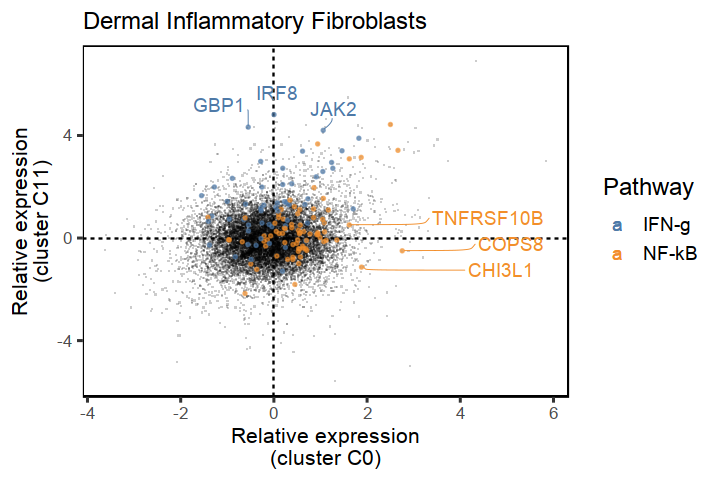

In [47]:
p3 <- .x %>% 
    dplyr::mutate(LABEL = case_when(
        feature %in% genesets_enrichr[['GO_Biological_Process_2018:NIK/NF-kappaB signaling (GO:0038061)']] ~ 'NF-kB',
        feature %in% genesets_enrichr[['GO_Biological_Process_2018:interferon-gamma-mediated signaling pathway (GO:0060333)']] ~ 'IFN-g',
        TRUE ~ ''
    )) %>% 
#     dplyr::arrange() %>% 
    ggplot(aes(C0, C11)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        geom_point(shape = '.', alpha = .2) + 
        geom_point(
            data = . %>% subset(LABEL != ''),
            aes(color = LABEL),
            size = .5, 
            alpha = .6
        ) + 
        geom_text_repel(
            data = . %>% subset(LABEL == 'IFN-g' & C0 < 2) %>% arrange(-C11) %>% head(3), 
            force             = 0.5,
            nudge_y           = 0.85,
            direction         = "x",
#             vjust             = 0,
            segment.size      = 0.2,
            segment.curvature = -0.1,            
 
            aes(label = feature, color = LABEL),
        ) + 
        geom_text_repel(
            data = . %>% subset(LABEL == 'NF-kB' & C11 < 2) %>% arrange(-C0) %>% head(3), 
            force             = 0.75,
            nudge_x           = 1.25,
            direction         = "y",
            hjust             = -1,
            segment.size      = 0.2,
            segment.curvature = -0.1,            
            aes(label = feature, color = LABEL),
        ) + 
        scale_color_tableau() + 
        labs(
            x = 'Relative expression\n(cluster C0)', y = 'Relative expression\n(cluster C11)', 
            subtitle = 'Dermal Inflammatory Fibroblasts', 
            color = 'Pathway'
        ) + 
        NULL

fig.size(4, 6)

p3

## Cache for figures

In [51]:
saveRDS(gsea_res, '/data/srlab2/ik936/Roche/data/eczema/cache_gsea.rds')

## Figure

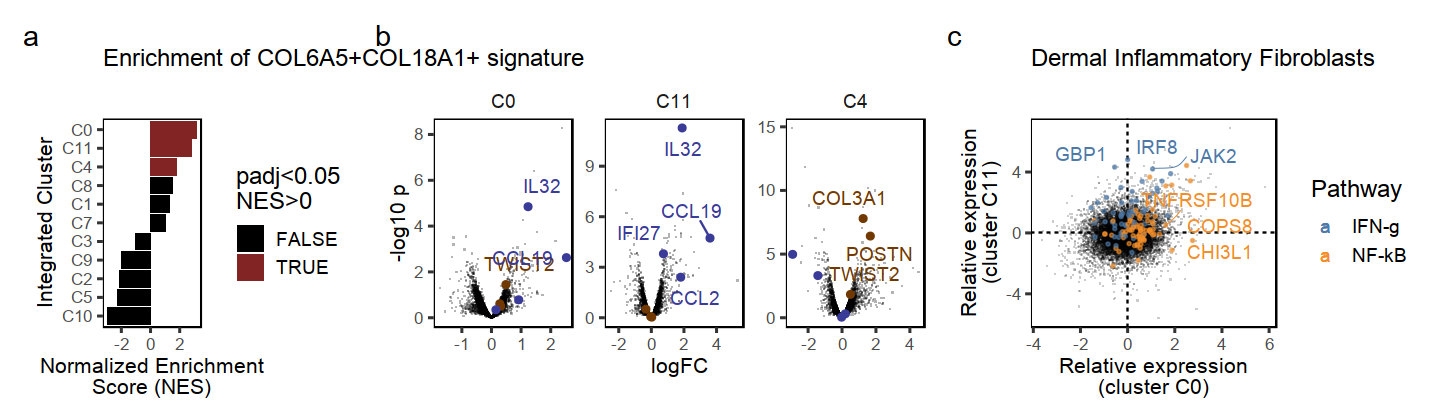

In [48]:
fig.size(3.5, 12)
set.seed(43)
(p1 | p2 | p3) + plot_layout(widths = c(.4, 2, 1)) + plot_annotation(tag_levels = 'a') 

# Cache

In [31]:
saveRDS(obj, '/data/srlab/ik936/Roche/data/eczema/obj_all.rds')

In [3]:
obj <- readRDS('/data/srlab/ik936/Roche/data/eczema/obj_all.rds')

In [ ]:
saveRDS(fib, '/data/srlab/ik936/Roche/data/eczema/obj_fib.rds')

In [4]:
fib <- readRDS('/data/srlab/ik936/Roche/data/eczema/obj_fib.rds')

In [20]:
query_obj$masc <- masc_res
query_obj$effects <- effects
fib$query <- query_obj


In [21]:
saveRDS(fib, '/data/srlab/ik936/Roche/data/eczema/obj_fib.rds')